In [1]:
#pip install torch torchvision clip-by-openai pillow


INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1.1.3, clip-by-openai==0.1.1.4, clip-by-openai==0.1.1.5, clip-by-openai==1.0.1, clip-by-openai==1.1, torch and torchvision==0.12.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch
    torchvision 0.12.0 depends on torch==1.11.0
    clip-by-openai 1.1 depends on torch<1

In [1]:
!pip install -r requirements.txt



Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rq6q7roo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rq6q7roo
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 68.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 66.3 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 48.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 37.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85

In [67]:
import torch
import clip
from PIL import Image
import json
import zipfile
import os


import numpy as np
import matplotlib.pyplot as plt

import gdown
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from torch.nn import functional as F
from transformers import pipeline
import random

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"


In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model=model.float()

In [68]:
 
import torch.nn as nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model, _ = clip.load('ViT-B/32',device=device)

    def forward(self, imgs, tokens):
        image_features = self.model.encode_image(imgs)
        match_text_features = self.model.encode_text(tokens)

        image_features = image_features /  image_features.norm(dim=-1, keepdim=True)
        match_text_features = match_text_features / match_text_features.norm(dim=-1, keepdim=True)

        similarity_match = image_features @ match_text_features.T
        return similarity_match
    def encode_text(self, tokens):
        return self.model.encode_text(tokens)

    def encode_image(self, imgs):
        return self.model.encode_image(imgs)

def compute_loss(similarity_match, labels):
    loss1 = F.cross_entropy(similarity_match, labels)
    loss2 = F.cross_entropy(similarity_match.T, labels)
    loss = (loss1 + loss2) / 2
    return loss

model = Model().cuda().float()
# 학습 전에 초기 상태 저장
torch.save(model.state_dict(), "clip_initial_weights.pth")


In [8]:
# Download dataset https://drive.google.com/file/d/1vN_wrMS4U3hFd6NyuP8_hEa_9T1cx3Bv/view?usp=sharing
 
# # wget.download(url, out=output)
# file_id = '1vN_wrMS4U3hFd6NyuP8_hEa_9T1cx3Bv'
# url = f'https://drive.google.com/uc?id={file_id}'
# # from google.colab import files
# # uploaded = files.upload()  # 파일 업로드 대화 상자가 열립니다.

# output = 'images.zip'  # The name for the downloaded file
# gdown.download(url, output, quiet=False)
# print(f"Downloaded: {output}")


Downloading...
From (original): https://drive.google.com/uc?id=1vN_wrMS4U3hFd6NyuP8_hEa_9T1cx3Bv
From (redirected): https://drive.google.com/uc?id=1vN_wrMS4U3hFd6NyuP8_hEa_9T1cx3Bv&confirm=t&uuid=be1d6093-c21d-46af-8b83-e33adb745ec8
To: /home/elicer/images.zip
100%|██████████| 6.85G/6.85G [02:05<00:00, 54.6MB/s]


Downloaded: images.zip


In [ ]:
#!unzip images.zip

Archive:  images.zip
replace images/MEN-Denim-id_00000080-01_7_additional.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:

# 압축 해제
zip_file = "images.zip"
output_dir = "images"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# captions.json 로드
with open("captions.json", "r") as f:
    captions = json.load(f)

# images와 captions 매핑 확인
print("Number of images:", len(captions))




# 경로 수정: 모든 파일 경로 앞에 "images/images/" 추가
updated_captions = {f"images/{key}": value for key, value in captions.items()}

# 수정된 captions.json 저장
with open("captions_updated.json", "w") as f:
    json.dump(updated_captions, f)

print("Updated captions.json with corrected paths!")
# captions_updated.json 사용
with open("captions_updated.json", "r") as f:
    captions = json.load(f)



Number of images: 42544
Updated captions.json with corrected paths!


In [51]:
print("Updated captions.json with corrected paths!")
# captions_updated.json 사용
with open("captions_updated.json", "r") as f:
    captions = json.load(f)
output_dir = "images"


Updated captions.json with corrected paths!


In [69]:
# 이미지-캡션 쌍 생성
image_caption_pairs = [(key, value) for key, value in captions.items()]

# 고정된 시드 설정
torch.manual_seed(42)  # 시드값 고정
# 데이터셋을 80:20으로 나누기
train_size = int(0.8 * len(image_caption_pairs))
test_size = len(image_caption_pairs) - train_size
train_pairs, test_pairs = random_split(image_caption_pairs, [train_size, test_size])

print(f"Train size: {len(train_pairs)}, Test size: {len(test_pairs)}")
 
class DeepFashionDataset(Dataset):
    def __init__(self, img_dir, pairs, preprocess):
        self.img_dir = img_dir
        self.pairs = pairs
        self.preprocess = preprocess

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, caption = self.pairs[idx]
        full_img_path = os.path.join(self.img_dir, img_path)  # 이미지 전체 경로
        image = self.preprocess(Image.open(full_img_path).convert("RGB"))
        return image, caption, full_img_path  # 이미지 경로도 반환


# 데이터로더 생성
train_dataset = DeepFashionDataset(output_dir, train_pairs, preprocess)
test_dataset = DeepFashionDataset(output_dir, test_pairs, preprocess)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train size: 34035, Test size: 8509


첫 번째 캡션: The sweater this person wears has long sleeves and it is with cotton fabric and solid color patterns. The neckline of the sweater is crew. This person wears a long pants, with denim fabric and solid color patterns. The outer clothing this person wears is with cotton fabric and pure color patterns. This female has neckwear. There is a ring on her finger.
첫 번째 이미지 경로: images/images/WOMEN-Jackets_Coats-id_00001582-03_4_full.jpg


/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  

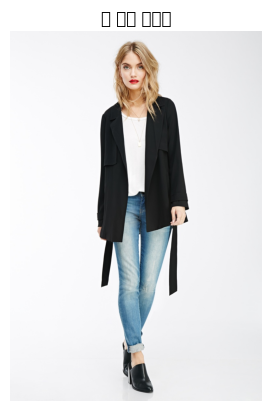

In [64]:
# 테스트 데이터셋에서 첫 번째 항목 확인
first_image, first_caption, first_img_path = test_dataset[0]

# 캡션 출력
print("첫 번째 캡션:", first_caption)

# 이미지 경로 출력
print("첫 번째 이미지 경로:", first_img_path)

# 이미지 시각화
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open(first_img_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("첫 번째 이미지")
plt.show()


In [70]:
def initialize_weights_randomly(model):
    """
    모델의 모든 가중치를 랜덤 초기화
    """
    for layer in model.parameters():
        if layer.requires_grad:  # 학습 가능한 레이어만 초기화
            nn.init.normal_(layer, mean=0.0, std=0.02)  # 정규분포로 초기화
 


In [71]:
#initialize_weights_randomly(model)

In [28]:
query_text = "The sweater this person wears has long sleeves and it is with cotton fabric and solid color patterns. The neckline of the sweater is crew. This person wears a long pants, with denim fabric and solid color patterns. The outer clothing this person wears is with cotton fabric and pure color patterns. This female has neckwear. There is a ring on her finger."


In [66]:
 #모델을 학습 전 !!초기상태!!로 복원#
###model.load_state_dict(torch.load("clip_initial_weights.pth"))


# 쿼리 정의
query_text = "a black sweater with checkered patterns"
#query_text = "he lower clothing is of long length. The fabric is cotton and it has plaid patterns."
#query_text = "The sweater this person wears has long sleeves and it is with cotton fabric and solid color patterns. The neckline of the sweater is crew. This person wears a long pants, with denim fabric and solid color patterns. The outer clothing this person wears is with cotton fabric and pure color patterns. This female has neckwear. There is a ring on her finger."

# 함수: 쿼리에 맞는 이미지 추출
def retrieve_images(query, dataloader, model, preprocess, top_k=5):
    # 쿼리 임베딩 계산
    with torch.no_grad():
        query_tokens = clip.tokenize([query]).to(device)
        query_features = model.encode_text(query_tokens)
        query_features /= query_features.norm(dim=-1, keepdim=True)

    image_features = []
    image_paths = []

    # # 데이터셋에서 이미지 임베딩 계산
    # for images, captions in tqdm(dataloader, desc="Processing images"):
    #     images = images.to(device)
    #     batch_paths = [caption for caption in captions]
    #   #  batch_paths = [img_path for img_path, _ in dataloader.dataset.pairs]  # 이미지 경로 추출
    #     with torch.no_grad():
    #         batch_features = model.encode_image(images)
    #         batch_features /= batch_features.norm(dim=-1, keepdim=True)
    #     image_features.append(batch_features)
    #     image_paths.extend(batch_paths)
        # 데이터셋에서 이미지 임베딩 계산
    for images, captions, paths in tqdm(dataloader, desc="Processing images"):  # 경로 포함
        images = images.to(device)
        with torch.no_grad():
            batch_features = model.encode_image(images)
            batch_features /= batch_features.norm(dim=-1, keepdim=True)
        image_features.append(batch_features)
        image_paths.extend(paths)  # 이미지 경로 추가
        if torch.isnan(batch_features).any():
           print("NaN detected in images in retrieve_images!")
        #print(batch_features)


    # 모든 임베딩 결합
    image_features = torch.cat(image_features, dim=0)

    # 유사도 계산
    similarities = (query_features @ image_features.T).squeeze(0)
    top_k_indices = similarities.topk(top_k).indices.tolist()
    top_k_images = [image_paths[i] for i in top_k_indices]
    print(similarities)
    return top_k_images


# 학습 전 테스트 데이터에서 쿼리와 가장 유사한 이미지 추출
print("Retrieving before training...")
top_k_before = retrieve_images(query_text, test_dataloader, model, preprocess)
print("Top-5 matching images before training:")
for i, img_path in enumerate(top_k_before):
    print(f"{i + 1}: {img_path}")




Retrieving before training...


Processing images: 100%|██████████| 266/266 [02:12<00:00,  2.01it/s]

tensor([0.2724, 0.2836, 0.2356,  ..., 0.2384, 0.2319, 0.2623], device='cuda:0')
Top-5 matching images before training:
1: images/images/MEN-Sweatshirts_Hoodies-id_00005603-01_1_front.jpg
2: images/images/WOMEN-Blouses_Shirts-id_00000506-01_2_side.jpg
3: images/images/WOMEN-Cardigans-id_00002880-01_7_additional.jpg
4: images/images/MEN-Tees_Tanks-id_00002638-09_1_front.jpg
5: images/images/WOMEN-Sweaters-id_00003926-01_1_front.jpg


In [68]:
print("Top-K image paths:", top_k_before)


Top-K image paths: ['images/images/WOMEN-Jackets_Coats-id_00000157-03_7_additional.jpg', 'images/images/WOMEN-Blouses_Shirts-id_00000947-02_4_full.jpg', 'images/images/WOMEN-Sweaters-id_00003930-07_7_additional.jpg', 'images/images/WOMEN-Blouses_Shirts-id_00006236-02_4_full.jpg', 'images/images/WOMEN-Jackets_Coats-id_00007186-03_1_front.jpg']


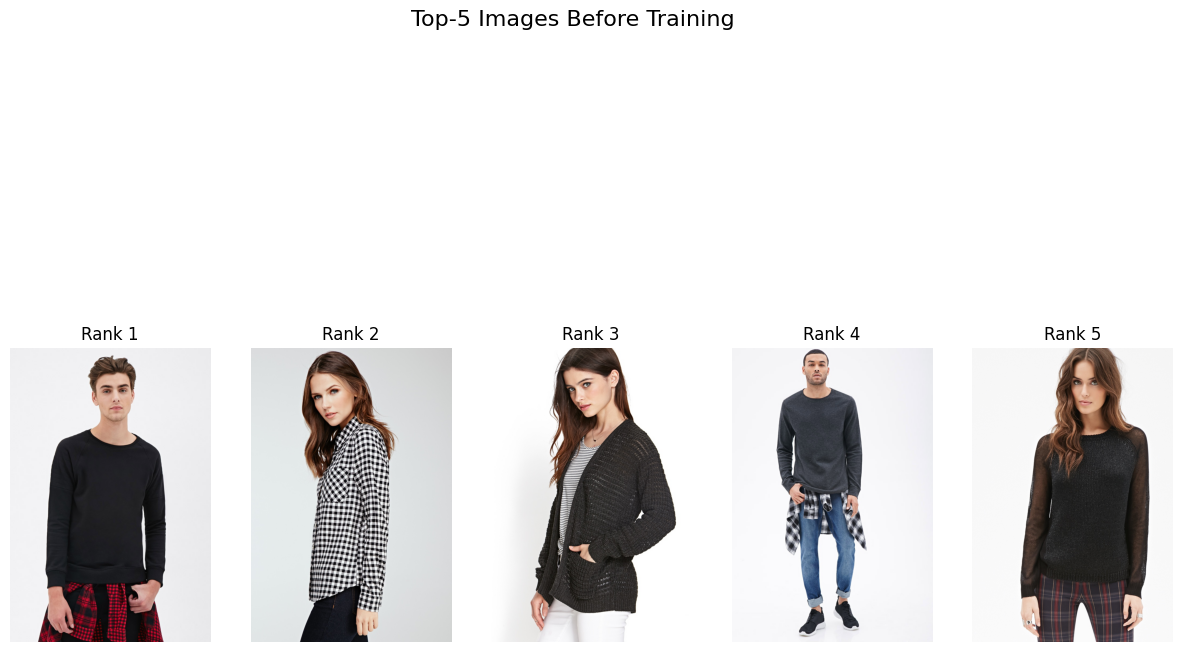

In [70]:
# 함수: 이미지를 시각화하여 보여주기
def display_images(image_paths, img_dir, title="Top-K Retrieved Images"):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)
    for i, img_path in enumerate(image_paths):
        image = Image.open(os.path.join(img_dir, img_path))
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Rank {i + 1}")
    plt.show()
    # 추출된 이미지 시각화
#display_images(top_k_before, output_dir, title="Top-5 Images Before Training")
# 중복된 경로를 제거
corrected_image_paths = [os.path.relpath(path, start="images/images/") for path in top_k_before]

# 디렉토리 설정
output_dir = "./images/images"

# 시각화 함수 호출
display_images(corrected_image_paths, output_dir, title="Top-5 Images Before Training")



In [81]:
def recall_at_k(similarities, ground_truth, k):
    """
    Recall@K 계산 함수
    :param similarities: 쿼리와 데이터셋 간의 유사도 행렬
    :param ground_truth: 정답 인덱스 리스트
    :param k: 상위 K개의 검색 결과에서 정답 포함 여부 확인
    :return: Recall@K 값
    """
    correct_matches = 0
    num_queries = similarities.shape[0]
    print(num_queries)
    for i in range(num_queries):
        # 유사도 기준 상위 K 인덱스 추출
        top_k_indices = similarities[i].argsort(descending=True)[:k]
        if ground_truth[i] in top_k_indices:
            correct_matches += 1

    return correct_matches / num_queries


def recall_at_k_modified(similarities, expanded_ground_truth, k):
    correct_matches = 0
    num_queries = len(expanded_ground_truth)

    for i, gt_indices in enumerate(expanded_ground_truth):
        # 유사도 기준 상위 K 인덱스 추출
        top_k_indices = set(similarities[i].argsort(descending=True)[:k].tolist())
        #print(f"Query {i}: GT Indices = {gt_indices}, Top-K Indices = {top_k_indices}")
      
        # 교집합이 존재하면 정답으로 간주
        if gt_indices & top_k_indices:
            correct_matches += 1
       # print(correct_matches,num_queries)

    return correct_matches / num_queries
    
def expand_ground_truth(ground_truth, similarities, threshold=0.95):
    expanded_gt = []
    for i, gt in enumerate(ground_truth):
        # 유사도가 threshold 이상인 이미지를 정답 리스트에 추가
        print(similarities[i])
        similar_indices = torch.where(similarities[i] >= threshold)[0].tolist()
        expanded_gt.append(set(similar_indices))
    return expanded_gt



In [82]:
def evaluate_recall(dataloader, model, preprocess, k_values=[1, 5, 10]):
    """
    테스트셋에 대해 Recall@K를 평가
    """
    model.eval()
    image_features = []
    text_features = []
    ground_truth = []

    # 테스트 데이터셋의 이미지와 텍스트 임베딩 계산
    for idx, (images, captions, paths) in enumerate(tqdm(dataloader, desc="Processing test dataset")):
        images = images.to(device)
        with torch.no_grad():
            batch_image_features = model.encode_image(images)
            batch_text_features = model.encode_text(clip.tokenize(captions, truncate=True).to(device))

            batch_image_features /= batch_image_features.norm(dim=-1, keepdim=True)
            batch_text_features /= batch_text_features.norm(dim=-1, keepdim=True)

        image_features.append(batch_image_features)
        text_features.append(batch_text_features)
        ground_truth.extend(range(len(batch_text_features)))  # 정답 인덱스 설정

    # 전체 이미지와 텍스트 임베딩 결합
    image_features = torch.cat(image_features, dim=0)
    text_features = torch.cat(text_features, dim=0)

    # 유사도 행렬 계산
    similarities = text_features @ image_features.T
 

    # Recall@K 계산
    results = {}
    for k in k_values:
        recall = recall_at_k(similarities, ground_truth, k)
        results[f"Recall@{k}"] = recall
    # expanded_ground_truth = expand_ground_truth(ground_truth, similarities)

    # # Recall@K 계산
    # results = {}
    # for k in k_values:
    #     recall = recall_at_k_modified(similarities, expanded_ground_truth, k)
    #     results[f"Recall@{k}"] = recall
    return results


In [74]:
# 테스트셋에서 Recall@K 평가
recall_results = evaluate_recall(test_dataloader, model, preprocess)
print("Recall@K results on test dataset:")
for k, recall in recall_results.items():
    print(f"{k}: {recall:.4f}")


Processing test dataset: 100%|██████████| 266/266 [02:22<00:00,  1.86it/s]


tensor([0.2764, 0.2355, 0.1894,  ..., 0.2625, 0.2565, 0.2955], device='cuda:0')
tensor([0.2138, 0.2180, 0.2010,  ..., 0.2372, 0.1876, 0.2309], device='cuda:0')
tensor([0.2276, 0.2228, 0.2626,  ..., 0.2794, 0.2483, 0.2110], device='cuda:0')
tensor([0.1969, 0.2241, 0.2314,  ..., 0.2567, 0.2246, 0.2094], device='cuda:0')
tensor([0.2670, 0.2477, 0.2244,  ..., 0.2742, 0.2876, 0.2647], device='cuda:0')
tensor([0.2683, 0.1966, 0.1345,  ..., 0.2216, 0.2168, 0.2778], device='cuda:0')
tensor([0.2361, 0.2203, 0.1967,  ..., 0.2380, 0.2111, 0.2663], device='cuda:0')
tensor([0.2118, 0.2081, 0.2393,  ..., 0.2924, 0.2526, 0.2171], device='cuda:0')
tensor([0.2322, 0.2371, 0.1936,  ..., 0.2243, 0.2055, 0.2559], device='cuda:0')
tensor([0.2579, 0.2222, 0.1842,  ..., 0.2569, 0.2255, 0.2775], device='cuda:0')
tensor([0.2763, 0.2695, 0.1982,  ..., 0.2520, 0.2243, 0.3022], device='cuda:0')
tensor([0.2669, 0.2580, 0.2353,  ..., 0.2592, 0.2365, 0.2906], device='cuda:0')
tensor([0.2291, 0.2096, 0.2065,  ..., 0.

In [75]:
def loss_fn(logits_per_image, logits_per_text):
    assert logits_per_image.shape[0] == logits_per_image.shape[0] # logits' shape should be (nxn)
    assert logits_per_image.shape == logits_per_text.shape
    
    labels = torch.arange(logits_per_image.shape[0], device=DEVICE)
    loss_i = F.cross_entropy(logits_per_image, labels)
    loss_t = F.cross_entropy(logits_per_image, labels)
    loss = (loss_i + loss_t) / 2
    
    return loss

Epoch: 100%|██████████| 1/1 [13:06<00:00, 786.63s/it]

Epoch 1/1, Loss: 2.7053


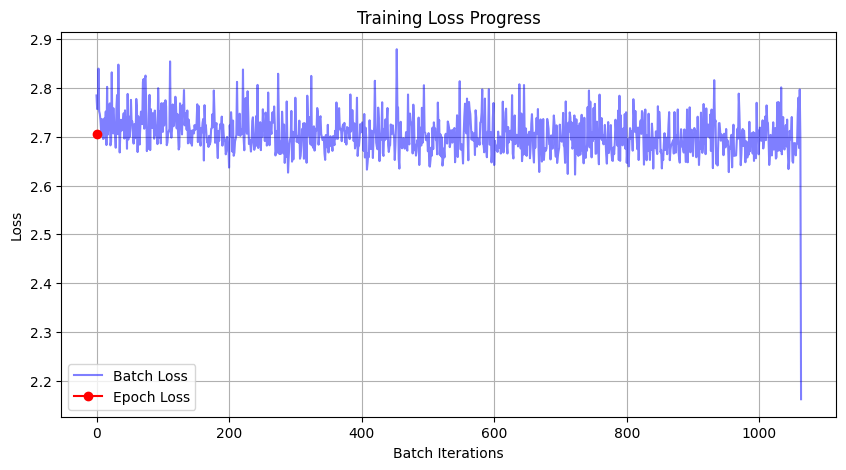

Retrieving after training...


Processing images: 100%|██████████| 266/266 [02:11<00:00,  2.02it/s]


tensor([-0.1374,  0.2317, -0.1019,  ...,  0.1738, -0.2521,  0.3668],
       device='cuda:0')
Top-5 matching images after training:
1: images/images/WOMEN-Blouses_Shirts-id_00007829-03_3_back.jpg
2: images/images/WOMEN-Blouses_Shirts-id_00000970-02_1_front.jpg
3: images/images/WOMEN-Blouses_Shirts-id_00005693-01_2_side.jpg
4: images/images/WOMEN-Blouses_Shirts-id_00007571-01_3_back.jpg
5: images/images/WOMEN-Blouses_Shirts-id_00001898-02_2_side.jpg


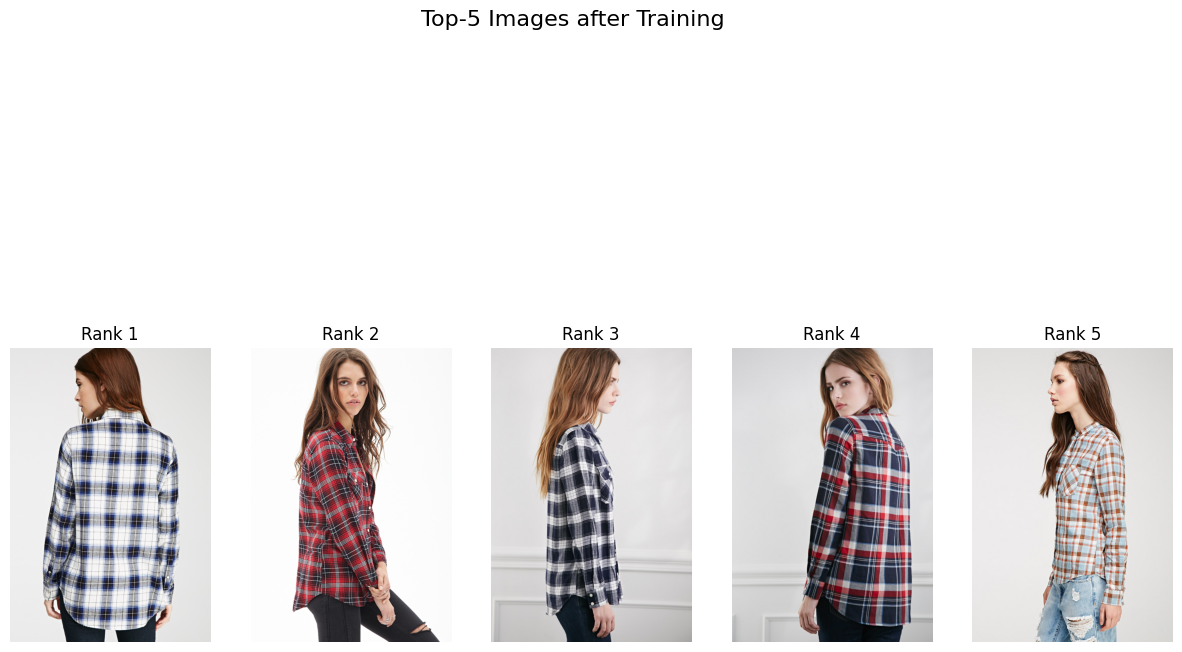

In [77]:
#모델을 학습 전 !!초기상태!!로 복원#
###model.load_state_dict(torch.load("clip_initial_weights.pth"))


# # 학습 함수 정의
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 1
temperature = 0.1
# Loss 저장 리스트
batch_losses = []
epoch_losses = []
model.train()
for epoch in tqdm(range(1, num_epochs + 1), desc="Epoch"):
    total_loss = 0
   # for batch in tqdm(train_dataloader, desc="Batch", leave=False):

    for images, texts,_ in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = images.to(device)
        
#             # 텍스트 자르기 또는 요약
       # texts = [truncate_text(text) for text in texts]  # 텍스트 자르기
        texts = clip.tokenize(texts, truncate=True).to(device)
        optimizer.zero_grad()
 
        # 모델 출력
        similarity_match = model(images, texts )
        # logits_per_image = outputs.logits_per_image
        # logits_per_text = outputs.logits_per_text
 # CLIP 모델 출력에서 텐서 추출
       # logits_per_image, logits_per_text = outputs
        # 손실 계산
        labels = torch.arange(len(images)).to(device) 
        loss = compute_loss(similarity_match, labels)
        # NaN 확인 및 처리
        if torch.isnan(loss):
            print("Loss is NaN! Skipping this batch.")
            continue

        # 역전파 및 최적화
        loss.backward()
       # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        total_loss += loss.item()
                # 배치 손실 저장
        batch_losses.append(loss.item())
    epoch_losses.append(total_loss / len(train_dataloader))
    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss / len(train_dataloader):.4f}")
  
 
# 손실 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label="Batch Loss", alpha=0.5, color='blue')
plt.plot([i * len(train_dataloader) for i in range(num_epochs)], epoch_losses, label="Epoch Loss", marker='o', color='red')
plt.xlabel("Batch Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Progress")
plt.legend()
plt.grid()
plt.show()

# 학습 후 테스트 데이터에서 쿼리와 가장 유사한 이미지 추출
print("Retrieving after training...")
top_k_after = retrieve_images(query_text, test_dataloader, model, preprocess)
print("Top-5 matching images after training:")
for i, img_path in enumerate(top_k_after):
    print(f"{i + 1}: {img_path}")

# 중복된 경로를 제거
corrected_image_paths = [os.path.relpath(path, start="images/images/") for path in top_k_after]

# 디렉토리 설정
output_dir = "./images/images"

# 시각화 함수 호출
display_images(corrected_image_paths, output_dir, title="Top-5 Images after Training")

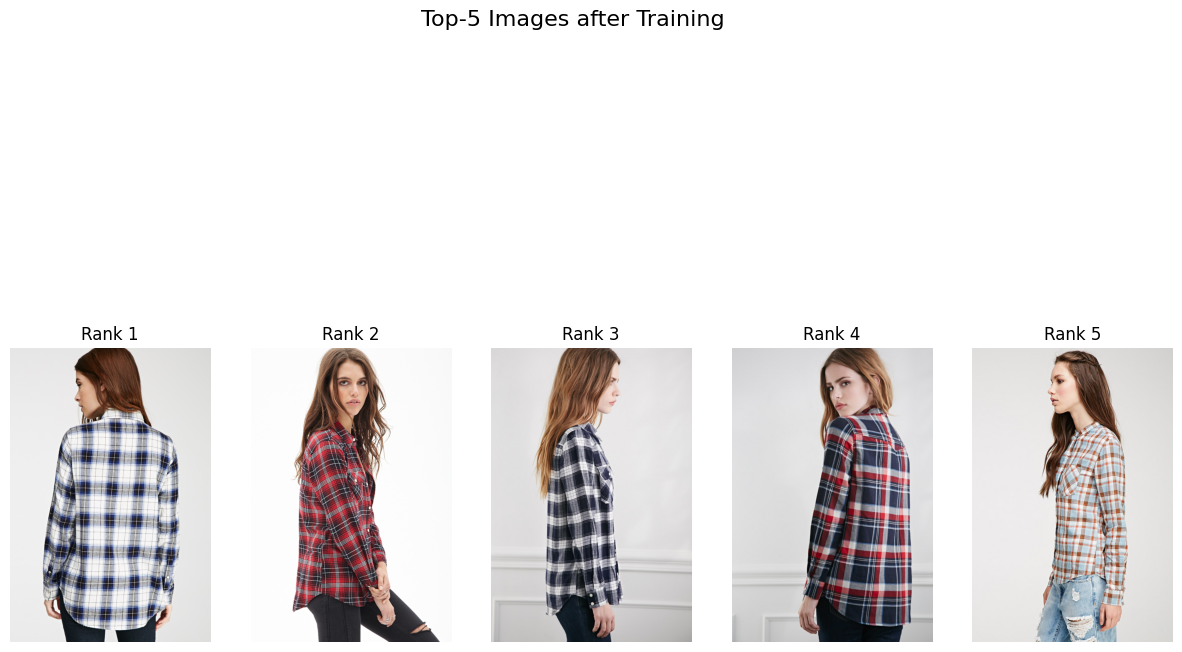

In [78]:
# 시각화 함수 호출
display_images(corrected_image_paths, output_dir, title="Top-5 Images after Training")

In [80]:
# 테스트셋에서 Recall@K 평가
recall_results = evaluate_recall(test_dataloader, model, preprocess)
print("Recall@K results on test dataset:")
for k, recall in recall_results.items():
    print(f"{k}: {recall:.4f}")




Processing test dataset: 100%|██████████| 266/266 [02:24<00:00,  1.84it/s]


8509
8509
8509
Recall@K results on test dataset:
Recall@1: 0.0001
Recall@5: 0.0011
Recall@10: 0.0022


In [39]:
# 테스트셋에서 Recall@K 평가
recall_results = evaluate_recall(test_dataloader, model, preprocess)
print("Recall@K results on test dataset:")
for k, recall in recall_results.items():
    print(f"{k}: {recall:.4f}")

#이거 결과는 loss nan오류 고치기전 !!!!! 안봐도됨!!!

Processing test dataset: 100%|██████████| 266/266 [02:32<00:00,  1.74it/s]


Recall@K results on test dataset:
Recall@1: 0.0313
Recall@5: 0.1563
Recall@10: 0.3126


In [20]:
# import torch
# import torch.nn as nn
# model=model.float()
# class CrossModalAttentionModel(nn.Module):
#     def __init__(self, clip_model, embed_dim, num_heads):
#         super(CrossModalAttentionModel, self).__init__()
#         self.clip_model = clip_model

#         # Multihead Attention
#         self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

#         # Feedforward layer (optional)
#         self.fc = nn.Sequential(
#             nn.Linear(embed_dim, embed_dim),
#             nn.ReLU(),
#             nn.Linear(embed_dim, embed_dim)
#         )

#     # def forward(self, images, texts):
#     #     # Extract features from CLIP
#     #     image_features = self.clip_model.encode_image(images)
#     #     text_features = self.clip_model.encode_text(texts)

#     #     # Normalize features
#     #     image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#     #     text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#     #     # Reshape features for attention (Batch, Seq, Embed)
#     #     # Assuming both image and text have one token per sequence (you can adjust if using patch embeddings)
#     #     image_features = image_features.unsqueeze(1)  # Add sequence dimension
#     #     text_features = text_features.unsqueeze(1)

#     #     # Cross-Modal Attention
#     #     attn_output, _ = self.attention(query=image_features, key=text_features, value=text_features)

#     #     # Apply feedforward layer
#     #     output = self.fc(attn_output.squeeze(1))  # Remove sequence dimension
#     #     return output, image_features.squeeze(1), text_features.squeeze(1)
#     def forward(self, images, texts):
#             # Extract features from CLIP
#             image_features = self.clip_model.encode_image(images)
#             text_features = self.clip_model.encode_text(texts)

#             # Normalize features
#             image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#             text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#             # Convert to float32
#             image_features = image_features.to(torch.float32)
#             text_features = text_features.to(torch.float32)

#             # Reshape features for attention (Batch, Seq, Embed)
#             image_features = image_features.unsqueeze(1)
#             text_features = text_features.unsqueeze(1)

#             # Cross-Modal Attention
#             attn_output, _ = self.attention(query=image_features, key=text_features, value=text_features)

#             # Apply feedforward layer
#             output = self.fc(attn_output.squeeze(1))
#             return output, image_features.squeeze(1), text_features.squeeze(1)
#     def encode_image(self, images):
#         """Wrapper for encode_image in CLIP"""
#         return self.clip_model.encode_image(images)

#     def encode_text(self, texts):
#         """Wrapper for encode_text in CLIP"""
#         return self.clip_model.encode_text(texts)


Epoch 1/1: 100%|██████████| 1064/1064 [09:35<00:00,  1.85it/s]


Epoch 1/1, Loss: nan
Retrieving after training...


Processing images:   0%|          | 1/266 [00:00<02:11,  2.01it/s]

NaN detected in images in retrieve_images!


Processing images:   1%|          | 2/266 [00:00<02:11,  2.01it/s]

NaN detected in images in retrieve_images!


Processing images:   1%|          | 3/266 [00:01<02:10,  2.01it/s]

NaN detected in images in retrieve_images!


Processing images:   2%|▏         | 4/266 [00:01<02:10,  2.01it/s]

NaN detected in images in retrieve_images!


Processing images:   2%|▏         | 5/266 [00:02<02:10,  2.01it/s]

NaN detected in images in retrieve_images!


Processing images:   2%|▏         | 6/266 [00:02<02:09,  2.01it/s]

NaN detected in images in retrieve_images!


Processing images:   3%|▎         | 7/266 [00:03<02:04,  2.07it/s]

NaN detected in images in retrieve_images!


Processing images:   3%|▎         | 8/266 [00:03<02:02,  2.11it/s]

NaN detected in images in retrieve_images!


Processing images:   3%|▎         | 9/266 [00:04<02:00,  2.13it/s]

NaN detected in images in retrieve_images!


Processing images:   4%|▍         | 10/266 [00:04<01:59,  2.15it/s]

NaN detected in images in retrieve_images!


Processing images:   4%|▍         | 11/266 [00:05<01:58,  2.15it/s]

NaN detected in images in retrieve_images!


Processing images:   5%|▍         | 12/266 [00:05<01:57,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:   5%|▍         | 13/266 [00:06<01:56,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:   5%|▌         | 14/266 [00:06<01:56,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:   6%|▌         | 15/266 [00:07<01:54,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:   6%|▌         | 16/266 [00:07<01:54,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:   6%|▋         | 17/266 [00:08<01:53,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:   7%|▋         | 18/266 [00:08<01:52,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:   7%|▋         | 19/266 [00:08<01:52,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:   8%|▊         | 20/266 [00:09<01:52,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:   8%|▊         | 21/266 [00:09<01:52,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:   8%|▊         | 22/266 [00:10<01:51,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:   9%|▊         | 23/266 [00:10<01:50,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:   9%|▉         | 24/266 [00:11<01:50,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:   9%|▉         | 25/266 [00:11<01:49,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  10%|▉         | 26/266 [00:12<01:49,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  10%|█         | 27/266 [00:12<01:49,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  11%|█         | 28/266 [00:13<01:48,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  11%|█         | 29/266 [00:13<01:48,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  11%|█▏        | 30/266 [00:13<01:48,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  12%|█▏        | 31/266 [00:14<01:47,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  12%|█▏        | 32/266 [00:14<01:47,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  12%|█▏        | 33/266 [00:15<01:46,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  13%|█▎        | 34/266 [00:15<01:46,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  13%|█▎        | 35/266 [00:16<01:45,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  14%|█▎        | 36/266 [00:16<01:45,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  14%|█▍        | 37/266 [00:17<01:44,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  14%|█▍        | 38/266 [00:17<01:44,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  15%|█▍        | 39/266 [00:18<01:43,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  15%|█▌        | 40/266 [00:18<01:42,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  15%|█▌        | 41/266 [00:18<01:41,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  16%|█▌        | 42/266 [00:19<01:41,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  16%|█▌        | 43/266 [00:19<01:41,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  17%|█▋        | 44/266 [00:20<01:41,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  17%|█▋        | 45/266 [00:20<01:40,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  17%|█▋        | 46/266 [00:21<01:40,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  18%|█▊        | 47/266 [00:21<01:39,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  18%|█▊        | 48/266 [00:22<01:39,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  18%|█▊        | 49/266 [00:22<01:39,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  19%|█▉        | 50/266 [00:23<01:38,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  19%|█▉        | 51/266 [00:23<01:38,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  20%|█▉        | 52/266 [00:24<01:38,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  20%|█▉        | 53/266 [00:24<01:38,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  20%|██        | 54/266 [00:24<01:37,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  21%|██        | 55/266 [00:25<01:36,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  21%|██        | 56/266 [00:25<01:35,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  21%|██▏       | 57/266 [00:26<01:35,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  22%|██▏       | 58/266 [00:26<01:34,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  22%|██▏       | 59/266 [00:27<01:35,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  23%|██▎       | 60/266 [00:27<01:37,  2.12it/s]

NaN detected in images in retrieve_images!


Processing images:  23%|██▎       | 61/266 [00:28<01:36,  2.13it/s]

NaN detected in images in retrieve_images!


Processing images:  23%|██▎       | 62/266 [00:28<01:34,  2.15it/s]

NaN detected in images in retrieve_images!


Processing images:  24%|██▎       | 63/266 [00:29<01:34,  2.15it/s]

NaN detected in images in retrieve_images!


Processing images:  24%|██▍       | 64/266 [00:29<01:33,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  24%|██▍       | 65/266 [00:30<01:32,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  25%|██▍       | 66/266 [00:30<01:32,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  25%|██▌       | 67/266 [00:30<01:31,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  26%|██▌       | 68/266 [00:31<01:31,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  26%|██▌       | 69/266 [00:31<01:30,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  26%|██▋       | 70/266 [00:32<01:32,  2.12it/s]

NaN detected in images in retrieve_images!


Processing images:  27%|██▋       | 71/266 [00:32<01:33,  2.09it/s]

NaN detected in images in retrieve_images!


Processing images:  27%|██▋       | 72/266 [00:33<01:33,  2.07it/s]

NaN detected in images in retrieve_images!


Processing images:  27%|██▋       | 73/266 [00:33<01:33,  2.06it/s]

NaN detected in images in retrieve_images!


Processing images:  28%|██▊       | 74/266 [00:34<01:33,  2.05it/s]

NaN detected in images in retrieve_images!


Processing images:  28%|██▊       | 75/266 [00:34<01:33,  2.04it/s]

NaN detected in images in retrieve_images!


Processing images:  29%|██▊       | 76/266 [00:35<01:33,  2.03it/s]

NaN detected in images in retrieve_images!


Processing images:  29%|██▉       | 77/266 [00:35<01:33,  2.02it/s]

NaN detected in images in retrieve_images!


Processing images:  29%|██▉       | 78/266 [00:36<01:31,  2.05it/s]

NaN detected in images in retrieve_images!


Processing images:  30%|██▉       | 79/266 [00:36<01:29,  2.08it/s]

NaN detected in images in retrieve_images!


Processing images:  30%|███       | 80/266 [00:37<01:28,  2.11it/s]

NaN detected in images in retrieve_images!


Processing images:  30%|███       | 81/266 [00:37<01:26,  2.14it/s]

NaN detected in images in retrieve_images!


Processing images:  31%|███       | 82/266 [00:38<01:25,  2.15it/s]

NaN detected in images in retrieve_images!


Processing images:  31%|███       | 83/266 [00:38<01:24,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  32%|███▏      | 84/266 [00:39<01:23,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  32%|███▏      | 85/266 [00:39<01:23,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  32%|███▏      | 86/266 [00:39<01:22,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  33%|███▎      | 87/266 [00:40<01:21,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  33%|███▎      | 88/266 [00:40<01:20,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  33%|███▎      | 89/266 [00:41<01:20,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  34%|███▍      | 90/266 [00:41<01:20,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  34%|███▍      | 91/266 [00:42<01:19,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  35%|███▍      | 92/266 [00:42<01:18,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  35%|███▍      | 93/266 [00:43<01:18,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  35%|███▌      | 94/266 [00:43<01:18,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  36%|███▌      | 95/266 [00:44<01:18,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  36%|███▌      | 96/266 [00:44<01:17,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  36%|███▋      | 97/266 [00:44<01:17,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  37%|███▋      | 98/266 [00:45<01:16,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  37%|███▋      | 99/266 [00:45<01:16,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  38%|███▊      | 100/266 [00:46<01:15,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  38%|███▊      | 101/266 [00:46<01:15,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  38%|███▊      | 102/266 [00:47<01:14,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  39%|███▊      | 103/266 [00:47<01:14,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  39%|███▉      | 104/266 [00:48<01:13,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  39%|███▉      | 105/266 [00:48<01:13,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  40%|███▉      | 106/266 [00:49<01:13,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  40%|████      | 107/266 [00:49<01:13,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  41%|████      | 108/266 [00:49<01:12,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  41%|████      | 109/266 [00:50<01:11,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  41%|████▏     | 110/266 [00:50<01:11,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  42%|████▏     | 111/266 [00:51<01:10,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  42%|████▏     | 112/266 [00:51<01:10,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  42%|████▏     | 113/266 [00:52<01:09,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  43%|████▎     | 114/266 [00:52<01:09,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  43%|████▎     | 115/266 [00:53<01:08,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  44%|████▎     | 116/266 [00:53<01:08,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  44%|████▍     | 117/266 [00:54<01:07,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  44%|████▍     | 118/266 [00:54<01:07,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  45%|████▍     | 119/266 [00:54<01:06,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  45%|████▌     | 120/266 [00:55<01:06,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  45%|████▌     | 121/266 [00:55<01:06,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  46%|████▌     | 122/266 [00:56<01:05,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  46%|████▌     | 123/266 [00:56<01:05,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  47%|████▋     | 124/266 [00:57<01:04,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  47%|████▋     | 125/266 [00:57<01:04,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  47%|████▋     | 126/266 [00:58<01:03,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  48%|████▊     | 127/266 [00:58<01:03,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  48%|████▊     | 128/266 [00:59<01:02,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  48%|████▊     | 129/266 [00:59<01:02,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  49%|████▉     | 130/266 [01:00<01:01,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  49%|████▉     | 131/266 [01:00<01:01,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  50%|████▉     | 132/266 [01:00<01:00,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  50%|█████     | 133/266 [01:01<01:00,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  50%|█████     | 134/266 [01:01<01:00,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  51%|█████     | 135/266 [01:02<00:59,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  51%|█████     | 136/266 [01:02<00:59,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  52%|█████▏    | 137/266 [01:03<00:58,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  52%|█████▏    | 138/266 [01:03<00:58,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  52%|█████▏    | 139/266 [01:04<00:58,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  53%|█████▎    | 140/266 [01:04<00:57,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  53%|█████▎    | 141/266 [01:05<00:57,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  53%|█████▎    | 142/266 [01:05<00:56,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  54%|█████▍    | 143/266 [01:05<00:55,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  54%|█████▍    | 144/266 [01:06<00:55,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  55%|█████▍    | 145/266 [01:06<00:55,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  55%|█████▍    | 146/266 [01:07<00:54,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  55%|█████▌    | 147/266 [01:07<00:54,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  56%|█████▌    | 148/266 [01:08<00:53,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  56%|█████▌    | 149/266 [01:08<00:53,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  56%|█████▋    | 150/266 [01:09<00:52,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  57%|█████▋    | 151/266 [01:09<00:52,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  57%|█████▋    | 152/266 [01:10<00:51,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  58%|█████▊    | 153/266 [01:10<00:51,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  58%|█████▊    | 154/266 [01:10<00:51,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  58%|█████▊    | 155/266 [01:11<00:50,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  59%|█████▊    | 156/266 [01:11<00:50,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  59%|█████▉    | 157/266 [01:12<00:49,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  59%|█████▉    | 158/266 [01:12<00:49,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  60%|█████▉    | 159/266 [01:13<00:48,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  60%|██████    | 160/266 [01:13<00:48,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  61%|██████    | 161/266 [01:14<00:48,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  61%|██████    | 162/266 [01:14<00:47,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  61%|██████▏   | 163/266 [01:15<00:47,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  62%|██████▏   | 164/266 [01:15<00:46,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  62%|██████▏   | 165/266 [01:15<00:46,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  62%|██████▏   | 166/266 [01:16<00:45,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  63%|██████▎   | 167/266 [01:16<00:45,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  63%|██████▎   | 168/266 [01:17<00:44,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  64%|██████▎   | 169/266 [01:17<00:44,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  64%|██████▍   | 170/266 [01:18<00:43,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  64%|██████▍   | 171/266 [01:18<00:43,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  65%|██████▍   | 172/266 [01:19<00:42,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  65%|██████▌   | 173/266 [01:19<00:42,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  65%|██████▌   | 174/266 [01:20<00:41,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  66%|██████▌   | 175/266 [01:20<00:41,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  66%|██████▌   | 176/266 [01:20<00:41,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  67%|██████▋   | 177/266 [01:21<00:40,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  67%|██████▋   | 178/266 [01:21<00:40,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  67%|██████▋   | 179/266 [01:22<00:39,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  68%|██████▊   | 180/266 [01:22<00:39,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  68%|██████▊   | 181/266 [01:23<00:38,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  68%|██████▊   | 182/266 [01:23<00:38,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  69%|██████▉   | 183/266 [01:24<00:37,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  69%|██████▉   | 184/266 [01:24<00:37,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  70%|██████▉   | 185/266 [01:25<00:36,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  70%|██████▉   | 186/266 [01:25<00:36,  2.22it/s]

NaN detected in images in retrieve_images!


Processing images:  70%|███████   | 187/266 [01:25<00:35,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  71%|███████   | 188/266 [01:26<00:35,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  71%|███████   | 189/266 [01:26<00:34,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  71%|███████▏  | 190/266 [01:27<00:34,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  72%|███████▏  | 191/266 [01:27<00:34,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  72%|███████▏  | 192/266 [01:28<00:33,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  73%|███████▎  | 193/266 [01:28<00:33,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  73%|███████▎  | 194/266 [01:29<00:32,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  73%|███████▎  | 195/266 [01:29<00:32,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  74%|███████▎  | 196/266 [01:30<00:31,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  74%|███████▍  | 197/266 [01:30<00:31,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  74%|███████▍  | 198/266 [01:30<00:30,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  75%|███████▍  | 199/266 [01:31<00:30,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  75%|███████▌  | 200/266 [01:31<00:29,  2.21it/s]

NaN detected in images in retrieve_images!


Processing images:  76%|███████▌  | 201/266 [01:32<00:29,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  76%|███████▌  | 202/266 [01:32<00:29,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  76%|███████▋  | 203/266 [01:33<00:28,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  77%|███████▋  | 204/266 [01:33<00:28,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  77%|███████▋  | 205/266 [01:34<00:28,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  77%|███████▋  | 206/266 [01:34<00:27,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  78%|███████▊  | 207/266 [01:35<00:27,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  78%|███████▊  | 208/266 [01:35<00:26,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  79%|███████▊  | 209/266 [01:36<00:26,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  79%|███████▉  | 210/266 [01:36<00:25,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  79%|███████▉  | 211/266 [01:36<00:25,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  80%|███████▉  | 212/266 [01:37<00:24,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  80%|████████  | 213/266 [01:37<00:24,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  80%|████████  | 214/266 [01:38<00:23,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  81%|████████  | 215/266 [01:38<00:23,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  81%|████████  | 216/266 [01:39<00:22,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  82%|████████▏ | 217/266 [01:39<00:22,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  82%|████████▏ | 218/266 [01:40<00:21,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  82%|████████▏ | 219/266 [01:40<00:21,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  83%|████████▎ | 220/266 [01:41<00:21,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  83%|████████▎ | 221/266 [01:41<00:20,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  83%|████████▎ | 222/266 [01:41<00:20,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  84%|████████▍ | 223/266 [01:42<00:19,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  84%|████████▍ | 224/266 [01:42<00:19,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  85%|████████▍ | 225/266 [01:43<00:18,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  85%|████████▍ | 226/266 [01:43<00:18,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  85%|████████▌ | 227/266 [01:44<00:17,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  86%|████████▌ | 228/266 [01:44<00:17,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  86%|████████▌ | 229/266 [01:45<00:16,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  86%|████████▋ | 230/266 [01:45<00:16,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  87%|████████▋ | 231/266 [01:46<00:16,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  87%|████████▋ | 232/266 [01:46<00:15,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  88%|████████▊ | 233/266 [01:47<00:15,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  88%|████████▊ | 234/266 [01:47<00:14,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  88%|████████▊ | 235/266 [01:47<00:14,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  89%|████████▊ | 236/266 [01:48<00:13,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  89%|████████▉ | 237/266 [01:48<00:13,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  89%|████████▉ | 238/266 [01:49<00:12,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  90%|████████▉ | 239/266 [01:49<00:12,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  90%|█████████ | 240/266 [01:50<00:12,  2.16it/s]

NaN detected in images in retrieve_images!


Processing images:  91%|█████████ | 241/266 [01:50<00:11,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  91%|█████████ | 242/266 [01:51<00:10,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  91%|█████████▏| 243/266 [01:51<00:10,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  92%|█████████▏| 244/266 [01:52<00:10,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  92%|█████████▏| 245/266 [01:52<00:09,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  92%|█████████▏| 246/266 [01:52<00:09,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  93%|█████████▎| 247/266 [01:53<00:08,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  93%|█████████▎| 248/266 [01:53<00:08,  2.18it/s]

NaN detected in images in retrieve_images!


Processing images:  94%|█████████▎| 249/266 [01:54<00:07,  2.17it/s]

NaN detected in images in retrieve_images!


Processing images:  94%|█████████▍| 250/266 [01:54<00:07,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  94%|█████████▍| 251/266 [01:55<00:06,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  95%|█████████▍| 252/266 [01:55<00:06,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  95%|█████████▌| 253/266 [01:56<00:05,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  95%|█████████▌| 254/266 [01:56<00:05,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  96%|█████████▌| 255/266 [01:57<00:04,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  96%|█████████▌| 256/266 [01:57<00:04,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  97%|█████████▋| 257/266 [01:57<00:04,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  97%|█████████▋| 258/266 [01:58<00:03,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  97%|█████████▋| 259/266 [01:58<00:03,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images:  98%|█████████▊| 260/266 [01:59<00:02,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  98%|█████████▊| 261/266 [01:59<00:02,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  98%|█████████▊| 262/266 [02:00<00:01,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  99%|█████████▉| 263/266 [02:00<00:01,  2.19it/s]

NaN detected in images in retrieve_images!


Processing images:  99%|█████████▉| 264/266 [02:01<00:00,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images: 100%|█████████▉| 265/266 [02:01<00:00,  2.20it/s]

NaN detected in images in retrieve_images!


Processing images: 100%|██████████| 266/266 [02:02<00:00,  2.18it/s]

NaN detected in images in retrieve_images!
Top-5 matching images after training:
1: images/images/WOMEN-Cardigans-id_00002894-03_7_additional.jpg
2: images/images/WOMEN-Jackets_Coats-id_00001582-03_4_full.jpg
3: images/images/WOMEN-Dresses-id_00001370-04_1_front.jpg
4: images/images/WOMEN-Blouses_Shirts-id_00004602-02_2_side.jpg
5: images/images/MEN-Tees_Tanks-id_00007563-01_1_front.jpg


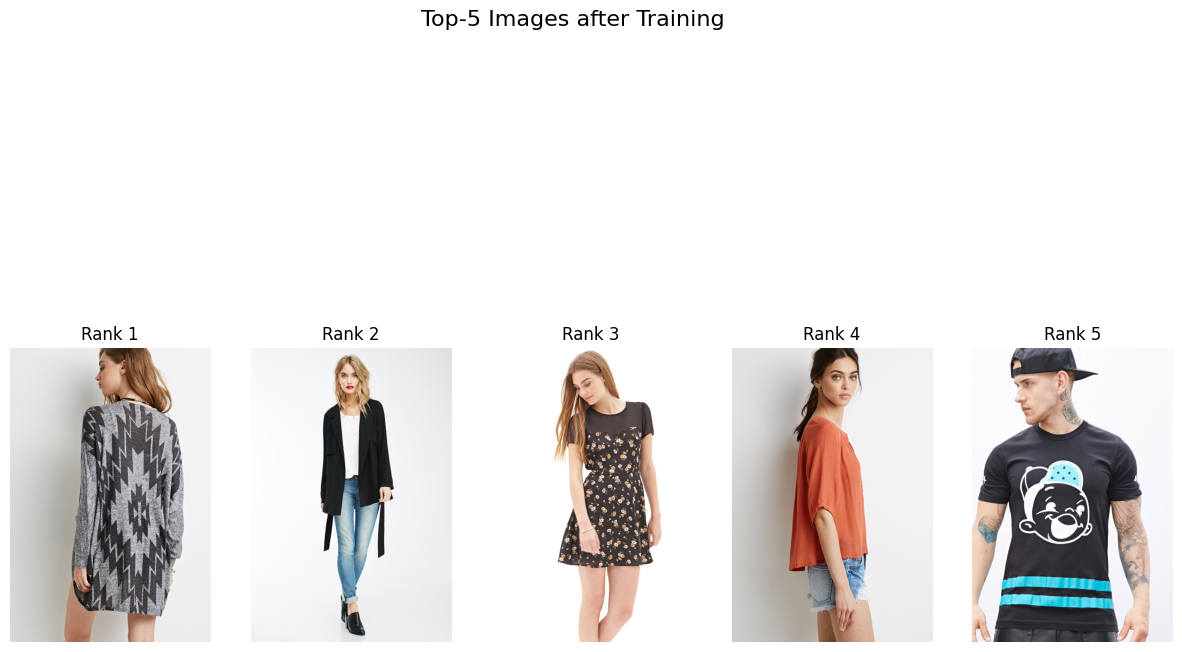

In [21]:
# # Cross-Modal Attention 모델 초기화
# embed_dim = 512  # CLIP 모델의 임베딩 크기
# num_heads = 8    # Attention 헤드 수
# cross_modal_model = CrossModalAttentionModel(model, embed_dim, num_heads).to(device)

# # 학습

# # Optimizer 설정
# optimizer = torch.optim.AdamW(cross_modal_model.parameters(), lr=1e-6)
# temperature = 0.1
# num_epochs = 1

# for epoch in range(num_epochs):
#     cross_modal_model.train()
#     total_loss = 0

#     for images, texts, _ in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
#         images = images.to(device)
#        # texts = [truncate_text(text) for text in texts]  # 텍스트 전처리
#         texts = clip.tokenize(texts, truncate=True).to(device)

#         optimizer.zero_grad()

#         # Forward pass
#         attn_output, image_features, text_features = cross_modal_model(images, texts)

#         # Contrastive Loss
#         logits_per_image = (attn_output @ text_features.T) / temperature
#         logits_per_text = logits_per_image.T
#         labels = torch.arange(len(images)).to(device)
#         loss = (F.cross_entropy(logits_per_image, labels) + F.cross_entropy(logits_per_text, labels)) / 2

#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader):.4f}")


#     # 학습 후 테스트 데이터에서 쿼리와 가장 유사한 이미지 추출
# print("Retrieving after training...")
# top_k_afterCM = retrieve_images(query_text, test_dataloader, cross_modal_model, preprocess)
# print("Top-5 matching images after training:")
# for i, img_path in enumerate(top_k_afterCM):
#     print(f"{i + 1}: {img_path}")

# # 중복된 경로를 제거
# corrected_image_pathsCM = [os.path.relpath(path, start="images/images/") for path in top_k_afterCM]

# # 디렉토리 설정
# output_dir = "./images/images"

# # 시각화 함수 호출
# display_images(corrected_image_pathsCM, output_dir, title="Top-5 Images after Training")


In [22]:
# # 테스트셋에서 Recall@K 평가
# recall_results = evaluate_recall(test_dataloader, cross_modal_model, preprocess)
# print("Recall@K results on test dataset:")
# for k, recall in recall_results.items():
#     print(f"{k}: {recall:.4f}")




Processing test dataset: 100%|██████████| 266/266 [02:08<00:00,  2.08it/s]


Recall@K results on test dataset:
Recall@1: 0.0313
Recall@5: 0.1563
Recall@10: 0.3126


In [14]:
# class CrossModalEncoder(nn.Module):
#     def __init__(self, image_dim, text_dim, hidden_dim, num_heads, num_layers):
#         super(CrossModalEncoder, self).__init__()

#         # Linear Projection for Image and Text
#         self.image_proj = nn.Linear(image_dim, hidden_dim)
#         self.text_proj = nn.Linear(text_dim, hidden_dim)

#         # Transformer Layers
#         self.transformer = nn.Transformer(
#             d_model=hidden_dim,
#             nhead=num_heads,
#             num_encoder_layers=num_layers,
#             num_decoder_layers=num_layers,
#             batch_first=True,
#         )

#     def forward(self, image_features, text_features):
#         # Project to shared hidden dimension
#         image_features = self.image_proj(image_features)
#         text_features = self.text_proj(text_features)

#         # Concatenate features for Transformer
#         combined_features = torch.cat([image_features, text_features], dim=1)

#         # Pass through Transformer
#         encoded_features = self.transformer(combined_features, combined_features)

#         return encoded_features


In [24]:
# class CrossModalAttentionModel(nn.Module):
#     def __init__(self, clip_model, cross_modal_encoder):
#         super(CrossModalAttentionModel, self).__init__()
#         self.clip_model = clip_model
#         self.cross_modal_encoder = cross_modal_encoder

#     def forward(self, images, texts):
#         # Extract features from CLIP
#         image_features = self.clip_model.encode_image(images)
#         text_features = self.clip_model.encode_text(texts)

#         # Apply Cross-Modal Encoder
#         encoded_features = self.cross_modal_encoder(image_features, text_features)

#         return encoded_features
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import clip

# class CrossModalModel(nn.Module):
#     def __init__(self, embed_dim=512, num_heads=8):
#         super().__init__()
#         self.clip_model, _ = clip.load('ViT-B/32', device=device)
        
#         # Cross-Modal Attention 추가
#         self.cross_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

#         # Feedforward layer (optional)
#         self.fc = nn.Sequential(
#             nn.Linear(embed_dim, embed_dim),
#             nn.ReLU(),
#             nn.Linear(embed_dim, embed_dim)
#         )
    
#     def encode_image(self, imgs):
#         # CLIP 이미지 인코더 호출
#         image_features = self.clip_model.encode_image(imgs)
#         return image_features

#     def encode_text(self, tokens):
#         # CLIP 텍스트 인코더 호출
#         text_features = self.clip_model.encode_text(tokens)
#         return text_features

#     def forward(self, imgs, tokens):
#         # 이미지와 텍스트 각각 인코딩
#         image_features = self.encode_image(imgs)
#         text_features = self.encode_text(tokens)

#         # Normalize features
#         image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#         text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#         # Reshape for Attention (Batch, Seq, Embed)
#         image_features = image_features.unsqueeze(1)  # 이미지에 Sequence dimension 추가
#         text_features = text_features.unsqueeze(1)

#         # Cross-Modal Attention 적용
#         attn_output, _ = self.cross_attention(query=image_features, key=text_features, value=text_features)
        
#         # Feedforward layer 적용 (선택)
#         output = self.fc(attn_output.squeeze(1))  # Sequence dimension 제거
#         return output


In [101]:
import torch
import torch.nn as nn
import clip

class CrossModalModel(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6):
        super().__init__()
        self.clip_model, _ = clip.load('ViT-B/32', device=device)
        
        # Transformer for Sequence-wise Attention
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Feedforward layer (optional)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
    
    def encode_image(self, imgs):
        # CLIP 이미지 인코더 호출
        image_features = self.clip_model.encode_image(imgs)
        return image_features

    def encode_text(self, tokens):
        # CLIP 텍스트 인코더 호출
        text_features = self.clip_model.encode_text(tokens)
        return text_features

    def forward(self, imgs, tokens):
        # 이미지와 텍스트 각각 인코딩
        image_features = self.encode_image(imgs)  # (Batch, Embed)
        text_features = self.encode_text(tokens)  # (Batch, Embed)

        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

         # Add sequence dimension for Transformer compatibility
        image_features = image_features.unsqueeze(1)  # (Batch, 1, Embed)
        text_features = text_features.unsqueeze(1)  # (Batch, 1, Embed)

        # Add CLS token for each modality (optional)
        cls_token_image = torch.zeros_like(image_features[:, :1, :])  # (Batch, 1, Embed)
        cls_token_text = torch.zeros_like(text_features[:, :1, :])    # (Batch, 1, Embed)
        # Add CLS token for each modality
        cls_token_image = torch.zeros_like(image_features)  # (Batch, 1, Embed)
        cls_token_text = torch.zeros_like(text_features)    # (Batch, 1, Embed)

        # Sequence 생성: [CLS] + image_features + text_features
        # image_seq = torch.cat([cls_token_image, image_features.unsqueeze(1)], dim=1)  # (Batch, Seq+1, Embed)
        # text_seq = torch.cat([cls_token_text, text_features.unsqueeze(1)], dim=1)     # (Batch, Seq+1, Embed)
 # Sequence 생성: [CLS] + image_features + text_features
        image_seq = torch.cat([cls_token_image, image_features], dim=1)  # (Batch, Seq+1, Embed)
        text_seq = torch.cat([cls_token_text, text_features], dim=1)     # (Batch, Seq+1, Embed)

        # Concatenate image and text sequences
        combined_seq = torch.cat([image_seq, text_seq], dim=1)  # (Batch, Seq+Seq+2, Embed)

        # Pass through Transformer for Cross-Modal Attention
        cross_modal_output = self.transformer(combined_seq)  # (Batch, Seq+Seq+2, Embed)

        # Extract CLS tokens for both image and text
        image_cls = cross_modal_output[:, 0, :]  # 첫 번째 CLS token (이미지)
        text_cls = cross_modal_output[:, image_seq.size(1), :]  # 중간 CLS token (텍스트)

        # Feedforward layer 적용 (선택)
        image_output = self.fc(image_cls)
        text_output = self.fc(text_cls)

        return image_output, text_output,text_features

# 모델 초기화
cmmodel = CrossModalModel(embed_dim=512, num_heads=8, num_layers=6).to(device).float()
torch.save(cmmodel.state_dict(), "cmclip_initial_weights.pth")

Retrieving before training...


Processing images: 100%|██████████| 266/266 [02:11<00:00,  2.02it/s]


tensor([0.2724, 0.2836, 0.2356,  ..., 0.2384, 0.2319, 0.2623], device='cuda:0')
Top-5 matching images after training:
1: images/images/MEN-Sweatshirts_Hoodies-id_00005603-01_1_front.jpg
2: images/images/WOMEN-Blouses_Shirts-id_00000506-01_2_side.jpg
3: images/images/WOMEN-Cardigans-id_00002880-01_7_additional.jpg
4: images/images/MEN-Tees_Tanks-id_00002638-09_1_front.jpg
5: images/images/WOMEN-Sweaters-id_00003926-01_1_front.jpg


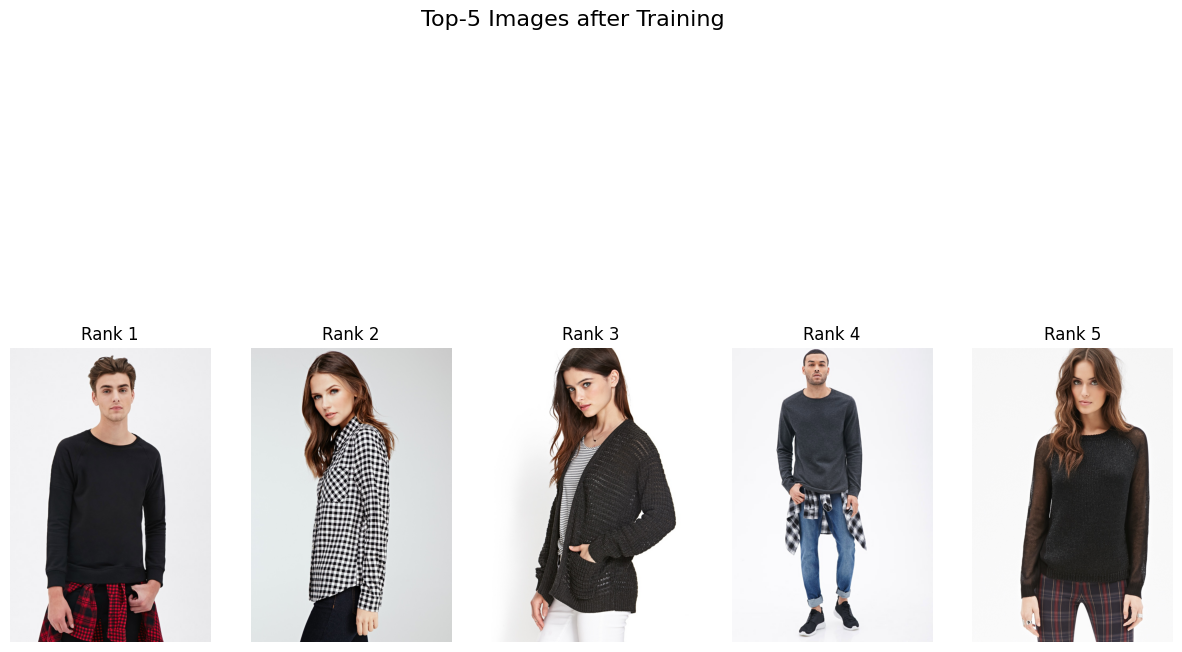

In [84]:
 # 학습 전 테스트 데이터에서 쿼리와 가장 유사한 이미지 추출
print("Retrieving before training...")
top_k_beforeCM = retrieve_images(query_text, test_dataloader, cmmodel, preprocess)

print("Top-5 matching images after training:")
for i, img_path in enumerate(top_k_beforeCM):
    print(f"{i + 1}: {img_path}")

# 중복된 경로를 제거
corrected_image_pathsCM = [os.path.relpath(path, start="images/images/") for path in top_k_beforeCM]

# 디렉토리 설정
output_dir = "./images/images"

# 시각화 함수 호출
display_images(corrected_image_pathsCM, output_dir, title="Top-5 Images after Training")


In [85]:
#학습 전 테스트셋에 대한리컬 값 구하기
# 테스트셋에서 Recall@K 평가
recall_results = evaluate_recall(test_dataloader, cmmodel, preprocess)
print("Recall@K results on test dataset:")
for k, recall in recall_results.items():
    print(f"{k}: {recall:.4f}")

Processing test dataset: 100%|██████████| 266/266 [02:22<00:00,  1.86it/s]


8509
8509
8509
Recall@K results on test dataset:
Recall@1: 0.0001
Recall@5: 0.0007
Recall@10: 0.0020


/tmp/ipykernel_148/1281021839.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmmodel.load_state_dict(torch.load("cmclip_initial_weights.pth"))# Cross-Modal Attention 모델

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   0%|          | 2/1064 [00:01<13:58,  1.27it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   0%|          | 3/1064 [00:02<13:32,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   0%|          | 4/1064 [00:03<13:23,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   0%|          | 5/1064 [00:03<13:12,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 6/1064 [00:04<13:10,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 7/1064 [00:05<13:09,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 8/1064 [00:06<13:06,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 9/1064 [00:06<13:03,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 10/1064 [00:07<13:00,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 11/1064 [00:08<12:59,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 12/1064 [00:08<12:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|          | 13/1064 [00:09<12:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|▏         | 14/1064 [00:10<12:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   1%|▏         | 15/1064 [00:11<12:52,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 16/1064 [00:11<12:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 17/1064 [00:12<12:52,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 18/1064 [00:13<12:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 19/1064 [00:14<12:50,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 20/1064 [00:14<12:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 21/1064 [00:15<12:49,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 22/1064 [00:16<12:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 23/1064 [00:17<12:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 24/1064 [00:17<12:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 25/1064 [00:18<12:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 26/1064 [00:19<12:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 27/1064 [00:20<12:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 28/1064 [00:20<12:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 29/1064 [00:21<12:55,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 30/1064 [00:22<13:04,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 31/1064 [00:23<13:10,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 32/1064 [00:23<13:13,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 33/1064 [00:24<13:16,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 34/1064 [00:25<13:17,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 35/1064 [00:26<13:17,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 36/1064 [00:27<13:17,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 37/1064 [00:27<13:17,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▎         | 38/1064 [00:28<13:17,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▎         | 39/1064 [00:29<13:16,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 40/1064 [00:30<13:18,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 41/1064 [00:30<13:18,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 42/1064 [00:31<13:19,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 43/1064 [00:32<13:17,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 44/1064 [00:33<13:13,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 45/1064 [00:33<12:59,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 46/1064 [00:34<12:51,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 47/1064 [00:35<12:45,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▍         | 48/1064 [00:36<12:40,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▍         | 49/1064 [00:36<12:38,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▍         | 50/1064 [00:37<12:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▍         | 51/1064 [00:38<12:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▍         | 52/1064 [00:39<12:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▍         | 53/1064 [00:39<12:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▌         | 54/1064 [00:40<12:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▌         | 55/1064 [00:41<12:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▌         | 56/1064 [00:42<12:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▌         | 57/1064 [00:42<12:29,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   5%|▌         | 58/1064 [00:43<12:40,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 59/1064 [00:44<12:45,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 60/1064 [00:45<12:44,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 61/1064 [00:45<12:44,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 62/1064 [00:46<12:36,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 63/1064 [00:47<12:31,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 64/1064 [00:48<12:26,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 65/1064 [00:48<12:23,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 66/1064 [00:49<12:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▋         | 67/1064 [00:50<12:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▋         | 68/1064 [00:51<12:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   6%|▋         | 69/1064 [00:51<12:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 70/1064 [00:52<12:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 71/1064 [00:53<12:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 72/1064 [00:54<12:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 73/1064 [00:54<12:15,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 74/1064 [00:55<12:13,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 75/1064 [00:56<12:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 76/1064 [00:57<12:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 77/1064 [00:57<12:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 78/1064 [00:58<12:11,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 79/1064 [00:59<12:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 80/1064 [01:00<12:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 81/1064 [01:00<12:11,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 82/1064 [01:01<12:10,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 83/1064 [01:02<12:08,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 84/1064 [01:03<12:08,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 85/1064 [01:03<12:07,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 86/1064 [01:04<12:05,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 87/1064 [01:05<12:05,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 88/1064 [01:05<12:06,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 89/1064 [01:06<12:04,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 90/1064 [01:07<12:01,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▊         | 91/1064 [01:08<12:01,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▊         | 92/1064 [01:08<11:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▊         | 93/1064 [01:09<11:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 94/1064 [01:10<11:56,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 95/1064 [01:11<11:59,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 96/1064 [01:11<11:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 97/1064 [01:12<11:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 98/1064 [01:13<11:57,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 99/1064 [01:14<11:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 100/1064 [01:14<11:54,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 101/1064 [01:15<11:55,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|▉         | 102/1064 [01:16<11:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|▉         | 103/1064 [01:17<11:52,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|▉         | 104/1064 [01:17<11:48,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|▉         | 105/1064 [01:18<11:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|▉         | 106/1064 [01:19<11:46,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|█         | 107/1064 [01:20<11:46,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|█         | 108/1064 [01:20<11:46,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|█         | 109/1064 [01:21<11:46,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|█         | 110/1064 [01:22<11:48,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  10%|█         | 111/1064 [01:23<11:45,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 112/1064 [01:23<11:43,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 113/1064 [01:24<11:43,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 114/1064 [01:25<11:42,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 115/1064 [01:25<11:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 116/1064 [01:26<11:40,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 117/1064 [01:27<11:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 118/1064 [01:28<11:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█         | 119/1064 [01:28<11:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█▏        | 120/1064 [01:29<11:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█▏        | 121/1064 [01:30<11:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  11%|█▏        | 122/1064 [01:31<11:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 123/1064 [01:31<11:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 124/1064 [01:32<11:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 125/1064 [01:33<11:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 126/1064 [01:34<11:33,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 127/1064 [01:34<11:33,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 128/1064 [01:35<11:33,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 129/1064 [01:36<11:37,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 130/1064 [01:37<11:45,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 131/1064 [01:37<11:50,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 132/1064 [01:38<11:55,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  12%|█▎        | 133/1064 [01:39<11:57,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 134/1064 [01:40<11:59,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 135/1064 [01:40<11:48,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 136/1064 [01:41<11:39,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 137/1064 [01:42<11:34,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 138/1064 [01:43<11:29,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 139/1064 [01:43<11:29,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 140/1064 [01:44<11:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 141/1064 [01:45<11:24,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 142/1064 [01:46<11:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 143/1064 [01:46<11:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▎        | 144/1064 [01:47<11:32,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▎        | 145/1064 [01:48<11:40,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▎        | 146/1064 [01:49<11:44,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 147/1064 [01:50<11:47,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 148/1064 [01:50<11:49,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 149/1064 [01:51<11:52,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 150/1064 [01:52<11:51,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 151/1064 [01:53<11:51,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 152/1064 [01:53<11:48,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 153/1064 [01:54<11:48,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 154/1064 [01:55<11:46,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▍        | 155/1064 [01:56<11:46,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▍        | 156/1064 [01:57<11:46,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▍        | 157/1064 [01:57<11:46,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▍        | 158/1064 [01:58<11:45,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▍        | 159/1064 [01:59<11:45,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▌        | 160/1064 [02:00<11:46,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▌        | 161/1064 [02:00<11:44,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▌        | 162/1064 [02:01<11:34,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▌        | 163/1064 [02:02<11:27,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  15%|█▌        | 164/1064 [02:03<11:22,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 165/1064 [02:03<11:16,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 166/1064 [02:04<11:11,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 167/1064 [02:05<11:09,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 168/1064 [02:06<11:07,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 169/1064 [02:06<11:06,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 170/1064 [02:07<11:04,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 171/1064 [02:08<10:59,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 172/1064 [02:09<10:58,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▋        | 173/1064 [02:09<10:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▋        | 174/1064 [02:10<10:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  16%|█▋        | 175/1064 [02:11<10:57,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 176/1064 [02:12<10:57,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 177/1064 [02:12<10:56,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 178/1064 [02:13<10:55,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 179/1064 [02:14<10:55,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 180/1064 [02:14<10:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 181/1064 [02:15<10:52,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 182/1064 [02:16<10:52,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 183/1064 [02:17<10:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 184/1064 [02:17<10:49,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 185/1064 [02:18<10:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 186/1064 [02:19<10:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 187/1064 [02:20<10:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 188/1064 [02:20<10:48,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 189/1064 [02:21<10:48,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 190/1064 [02:22<10:48,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 191/1064 [02:23<10:49,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 192/1064 [02:23<10:48,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 193/1064 [02:24<10:46,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 194/1064 [02:25<10:45,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 195/1064 [02:26<10:44,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 196/1064 [02:26<10:43,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▊        | 197/1064 [02:27<10:41,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▊        | 198/1064 [02:28<10:40,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▊        | 199/1064 [02:29<10:41,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 200/1064 [02:29<10:40,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 201/1064 [02:30<10:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 202/1064 [02:31<10:37,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 203/1064 [02:32<10:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 204/1064 [02:32<10:37,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 205/1064 [02:33<10:36,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 206/1064 [02:34<10:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 207/1064 [02:35<10:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|█▉        | 208/1064 [02:35<10:34,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|█▉        | 209/1064 [02:36<10:34,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|█▉        | 210/1064 [02:37<10:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|█▉        | 211/1064 [02:37<10:31,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|█▉        | 212/1064 [02:38<10:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|██        | 213/1064 [02:39<10:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|██        | 214/1064 [02:40<10:31,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|██        | 215/1064 [02:40<10:31,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|██        | 216/1064 [02:41<10:30,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|██        | 217/1064 [02:42<10:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  20%|██        | 218/1064 [02:43<10:29,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 219/1064 [02:43<10:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 220/1064 [02:44<10:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 221/1064 [02:45<10:25,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 222/1064 [02:46<10:24,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 223/1064 [02:46<10:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 224/1064 [02:47<10:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 225/1064 [02:48<10:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██        | 226/1064 [02:49<10:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██▏       | 227/1064 [02:49<10:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  21%|██▏       | 228/1064 [02:50<10:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 229/1064 [02:51<10:26,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 230/1064 [02:52<10:32,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 231/1064 [02:52<10:36,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 232/1064 [02:53<10:40,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 233/1064 [02:54<10:41,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 234/1064 [02:55<10:43,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 235/1064 [02:56<10:39,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 236/1064 [02:56<10:30,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 237/1064 [02:57<10:34,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 238/1064 [02:58<10:37,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 239/1064 [02:59<10:39,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 240/1064 [02:59<10:40,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 241/1064 [03:00<10:39,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 242/1064 [03:01<10:39,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 243/1064 [03:02<10:39,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 244/1064 [03:03<10:40,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 245/1064 [03:03<10:38,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 246/1064 [03:04<10:40,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 247/1064 [03:05<10:29,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 248/1064 [03:06<10:22,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 249/1064 [03:06<10:16,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 250/1064 [03:07<10:09,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▎       | 251/1064 [03:08<10:06,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▎       | 252/1064 [03:09<10:04,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 253/1064 [03:09<10:01,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 254/1064 [03:10<10:01,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 255/1064 [03:11<10:02,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 256/1064 [03:11<10:00,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 257/1064 [03:12<09:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 258/1064 [03:13<09:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 259/1064 [03:14<09:57,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 260/1064 [03:14<09:56,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▍       | 261/1064 [03:15<09:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▍       | 262/1064 [03:16<09:51,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▍       | 263/1064 [03:17<09:48,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▍       | 264/1064 [03:17<09:46,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▍       | 265/1064 [03:18<09:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▌       | 266/1064 [03:19<09:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▌       | 267/1064 [03:20<09:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▌       | 268/1064 [03:20<09:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▌       | 269/1064 [03:21<09:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▌       | 270/1064 [03:22<09:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  25%|██▌       | 271/1064 [03:23<09:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 272/1064 [03:23<09:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 273/1064 [03:24<09:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 274/1064 [03:25<09:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 275/1064 [03:25<09:42,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 276/1064 [03:26<09:41,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 277/1064 [03:27<09:41,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 278/1064 [03:28<09:38,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 279/1064 [03:28<09:36,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▋       | 280/1064 [03:29<09:37,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  26%|██▋       | 281/1064 [03:30<09:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 282/1064 [03:31<09:34,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 283/1064 [03:31<09:34,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 284/1064 [03:32<09:34,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 285/1064 [03:33<09:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 286/1064 [03:34<09:31,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 287/1064 [03:34<09:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 288/1064 [03:35<09:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 289/1064 [03:36<09:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 290/1064 [03:37<09:41,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 291/1064 [03:37<09:46,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 292/1064 [03:38<09:49,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 293/1064 [03:39<09:52,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 294/1064 [03:40<09:48,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 295/1064 [03:40<09:41,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 296/1064 [03:41<09:36,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 297/1064 [03:42<09:34,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 298/1064 [03:43<09:39,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 299/1064 [03:43<09:44,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 300/1064 [03:44<09:46,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 301/1064 [03:45<09:47,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 302/1064 [03:46<09:47,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 303/1064 [03:47<09:46,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▊       | 304/1064 [03:47<09:42,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▊       | 305/1064 [03:48<09:36,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 306/1064 [03:49<09:31,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 307/1064 [03:49<09:26,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 308/1064 [03:50<09:22,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 309/1064 [03:51<09:19,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 310/1064 [03:52<09:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 311/1064 [03:52<09:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 312/1064 [03:53<09:24,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 313/1064 [03:54<09:29,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|██▉       | 314/1064 [03:55<09:32,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|██▉       | 315/1064 [03:56<09:30,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|██▉       | 316/1064 [03:56<09:32,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|██▉       | 317/1064 [03:57<09:32,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|██▉       | 318/1064 [03:58<09:34,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|██▉       | 319/1064 [03:59<09:34,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|███       | 320/1064 [03:59<09:34,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|███       | 321/1064 [04:00<09:35,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|███       | 322/1064 [04:01<09:30,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|███       | 323/1064 [04:02<09:30,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  30%|███       | 324/1064 [04:02<09:31,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 325/1064 [04:03<09:30,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 326/1064 [04:04<09:31,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 327/1064 [04:05<09:32,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 328/1064 [04:06<09:31,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 329/1064 [04:06<09:22,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 330/1064 [04:07<09:14,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 331/1064 [04:08<09:08,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███       | 332/1064 [04:09<09:04,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███▏      | 333/1064 [04:09<09:01,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███▏      | 334/1064 [04:10<08:59,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  31%|███▏      | 335/1064 [04:11<08:56,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 336/1064 [04:11<08:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 337/1064 [04:12<08:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 338/1064 [04:13<08:52,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 339/1064 [04:14<08:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 340/1064 [04:14<08:52,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 341/1064 [04:15<08:49,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 342/1064 [04:16<08:48,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 343/1064 [04:17<08:50,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 344/1064 [04:17<08:51,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 345/1064 [04:18<08:50,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 346/1064 [04:19<08:48,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 347/1064 [04:20<08:49,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 348/1064 [04:20<08:49,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 349/1064 [04:21<08:48,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 350/1064 [04:22<08:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 351/1064 [04:23<08:47,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 352/1064 [04:23<08:48,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 353/1064 [04:24<08:46,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 354/1064 [04:25<08:44,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 355/1064 [04:25<08:43,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 356/1064 [04:26<08:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▎      | 357/1064 [04:27<08:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▎      | 358/1064 [04:28<08:41,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▎      | 359/1064 [04:28<08:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 360/1064 [04:29<08:40,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 361/1064 [04:30<08:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 362/1064 [04:31<08:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 363/1064 [04:31<08:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 364/1064 [04:32<08:37,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 365/1064 [04:33<08:36,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 366/1064 [04:34<08:34,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 367/1064 [04:34<08:36,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▍      | 368/1064 [04:35<08:33,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▍      | 369/1064 [04:36<08:32,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▍      | 370/1064 [04:37<08:33,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▍      | 371/1064 [04:37<08:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▍      | 372/1064 [04:38<08:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▌      | 373/1064 [04:39<08:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▌      | 374/1064 [04:40<08:31,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▌      | 375/1064 [04:40<08:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▌      | 376/1064 [04:41<08:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  35%|███▌      | 377/1064 [04:42<08:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 378/1064 [04:42<08:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 379/1064 [04:43<08:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 380/1064 [04:44<08:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 381/1064 [04:45<08:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 382/1064 [04:45<08:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 383/1064 [04:46<08:23,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 384/1064 [04:47<08:20,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 385/1064 [04:48<08:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▋      | 386/1064 [04:48<08:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▋      | 387/1064 [04:49<08:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  36%|███▋      | 388/1064 [04:50<08:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 389/1064 [04:51<08:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 390/1064 [04:51<08:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 391/1064 [04:52<08:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 392/1064 [04:53<08:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 393/1064 [04:54<08:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 394/1064 [04:54<08:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 395/1064 [04:55<08:15,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 396/1064 [04:56<08:15,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 397/1064 [04:57<08:15,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 398/1064 [04:57<08:14,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 399/1064 [04:58<08:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 400/1064 [04:59<08:11,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 401/1064 [05:00<08:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 402/1064 [05:00<08:08,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 403/1064 [05:01<08:07,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 404/1064 [05:02<08:09,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 405/1064 [05:02<08:08,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 406/1064 [05:03<08:06,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 407/1064 [05:04<08:05,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])
attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 409/1064 [05:06<08:19,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▊      | 410/1064 [05:06<08:12,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▊      | 411/1064 [05:07<08:08,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▊      | 412/1064 [05:08<08:05,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 413/1064 [05:08<08:00,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 414/1064 [05:09<07:59,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 415/1064 [05:10<07:57,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 416/1064 [05:11<07:55,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 417/1064 [05:11<07:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 418/1064 [05:12<07:52,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 419/1064 [05:13<07:51,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 420/1064 [05:14<07:50,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|███▉      | 421/1064 [05:14<07:50,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|███▉      | 422/1064 [05:15<07:50,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|███▉      | 423/1064 [05:16<07:49,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|███▉      | 424/1064 [05:16<07:47,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|███▉      | 425/1064 [05:17<07:46,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|████      | 426/1064 [05:18<07:43,  1.38it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|████      | 427/1064 [05:19<07:43,  1.38it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|████      | 428/1064 [05:19<07:42,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|████      | 429/1064 [05:20<07:42,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  40%|████      | 430/1064 [05:21<07:43,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 431/1064 [05:22<07:42,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 432/1064 [05:22<07:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 433/1064 [05:23<07:41,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 434/1064 [05:24<07:41,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 435/1064 [05:25<07:39,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 436/1064 [05:25<07:38,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 437/1064 [05:26<07:38,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████      | 438/1064 [05:27<07:37,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████▏     | 439/1064 [05:27<07:37,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████▏     | 440/1064 [05:28<07:37,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  41%|████▏     | 441/1064 [05:29<07:37,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 442/1064 [05:30<07:35,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 443/1064 [05:30<07:33,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 444/1064 [05:31<07:33,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 445/1064 [05:32<07:34,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 446/1064 [05:33<07:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 447/1064 [05:33<07:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 448/1064 [05:34<07:32,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 449/1064 [05:35<07:30,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 450/1064 [05:36<07:29,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 451/1064 [05:36<07:28,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 452/1064 [05:37<07:29,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 453/1064 [05:38<07:28,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 454/1064 [05:38<07:29,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 455/1064 [05:39<07:28,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 456/1064 [05:40<07:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 457/1064 [05:41<07:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 458/1064 [05:41<07:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 459/1064 [05:42<07:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 460/1064 [05:43<07:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 461/1064 [05:44<07:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 462/1064 [05:44<07:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▎     | 463/1064 [05:45<07:27,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▎     | 464/1064 [05:46<07:26,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▎     | 465/1064 [05:47<07:26,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 466/1064 [05:47<07:24,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 467/1064 [05:48<07:23,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 468/1064 [05:49<07:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 469/1064 [05:50<07:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 470/1064 [05:50<07:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 471/1064 [05:51<07:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 472/1064 [05:52<07:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 473/1064 [05:53<07:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▍     | 474/1064 [05:53<07:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▍     | 475/1064 [05:54<07:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▍     | 476/1064 [05:55<07:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▍     | 477/1064 [05:56<07:16,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▍     | 478/1064 [05:56<07:14,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▌     | 479/1064 [05:57<07:13,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▌     | 480/1064 [05:58<07:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▌     | 481/1064 [05:59<07:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▌     | 482/1064 [05:59<07:12,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▌     | 483/1064 [06:00<07:11,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  45%|████▌     | 484/1064 [06:01<07:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 485/1064 [06:01<07:09,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 486/1064 [06:02<07:08,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 487/1064 [06:03<07:08,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 488/1064 [06:04<07:08,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 489/1064 [06:04<07:06,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 490/1064 [06:05<07:06,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 491/1064 [06:06<07:12,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 492/1064 [06:07<07:16,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▋     | 493/1064 [06:08<07:18,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  46%|████▋     | 494/1064 [06:08<07:20,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 495/1064 [06:09<07:21,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 496/1064 [06:10<07:20,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 497/1064 [06:11<07:20,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 498/1064 [06:11<07:20,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 499/1064 [06:12<07:20,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 500/1064 [06:13<07:18,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 501/1064 [06:14<07:18,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 502/1064 [06:15<07:18,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 503/1064 [06:15<07:18,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 504/1064 [06:16<07:17,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 505/1064 [06:17<07:16,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 506/1064 [06:18<07:15,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 507/1064 [06:18<07:06,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 508/1064 [06:19<06:58,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 509/1064 [06:20<06:54,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 510/1064 [06:21<06:51,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 511/1064 [06:21<06:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 512/1064 [06:22<06:47,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 513/1064 [06:23<06:47,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 514/1064 [06:24<06:46,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 515/1064 [06:24<06:45,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 516/1064 [06:25<06:44,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▊     | 517/1064 [06:26<06:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▊     | 518/1064 [06:27<06:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 519/1064 [06:27<06:41,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 520/1064 [06:28<06:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 521/1064 [06:29<06:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 522/1064 [06:29<06:38,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 523/1064 [06:30<06:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 524/1064 [06:31<06:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 525/1064 [06:32<06:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 526/1064 [06:32<06:37,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|████▉     | 527/1064 [06:33<06:36,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|████▉     | 528/1064 [06:34<06:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|████▉     | 529/1064 [06:35<06:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|████▉     | 530/1064 [06:35<06:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|████▉     | 531/1064 [06:36<06:32,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|█████     | 532/1064 [06:37<06:31,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|█████     | 533/1064 [06:38<06:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|█████     | 534/1064 [06:38<06:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|█████     | 535/1064 [06:39<06:29,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|█████     | 536/1064 [06:40<06:29,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  50%|█████     | 537/1064 [06:41<06:28,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 538/1064 [06:41<06:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 539/1064 [06:42<06:27,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 540/1064 [06:43<06:26,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 541/1064 [06:43<06:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 542/1064 [06:44<06:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 543/1064 [06:45<06:27,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 544/1064 [06:46<06:26,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 545/1064 [06:46<06:25,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████▏    | 546/1064 [06:47<06:23,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  51%|█████▏    | 547/1064 [06:48<06:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 548/1064 [06:49<06:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 549/1064 [06:49<06:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 550/1064 [06:50<06:19,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 551/1064 [06:51<06:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 552/1064 [06:52<06:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 553/1064 [06:52<06:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 554/1064 [06:53<06:18,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 555/1064 [06:54<06:18,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 556/1064 [06:55<06:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 557/1064 [06:55<06:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 558/1064 [06:56<06:15,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 559/1064 [06:57<06:15,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 560/1064 [06:58<06:14,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 561/1064 [06:58<06:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 562/1064 [06:59<06:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 563/1064 [07:00<06:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 564/1064 [07:01<06:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 565/1064 [07:01<06:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 566/1064 [07:02<06:09,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 567/1064 [07:03<06:09,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 568/1064 [07:04<06:07,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 569/1064 [07:04<06:12,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▎    | 570/1064 [07:05<06:16,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▎    | 571/1064 [07:06<06:18,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 572/1064 [07:07<06:19,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 573/1064 [07:07<06:20,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 574/1064 [07:08<06:19,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 575/1064 [07:09<06:20,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 576/1064 [07:10<06:19,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 577/1064 [07:11<06:18,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 578/1064 [07:11<06:18,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 579/1064 [07:12<06:17,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▍    | 580/1064 [07:13<06:16,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▍    | 581/1064 [07:14<06:16,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▍    | 582/1064 [07:14<06:15,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▍    | 583/1064 [07:15<06:15,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▍    | 584/1064 [07:16<06:13,  1.28it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▍    | 585/1064 [07:17<06:07,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▌    | 586/1064 [07:17<06:03,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▌    | 587/1064 [07:18<06:00,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▌    | 588/1064 [07:19<05:56,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▌    | 589/1064 [07:20<05:54,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  55%|█████▌    | 590/1064 [07:20<05:52,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 591/1064 [07:21<05:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 592/1064 [07:22<05:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 593/1064 [07:23<05:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 594/1064 [07:23<05:47,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 595/1064 [07:24<05:46,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 596/1064 [07:25<05:45,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 597/1064 [07:26<05:44,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 598/1064 [07:26<05:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▋    | 599/1064 [07:27<05:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▋    | 600/1064 [07:28<05:42,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  56%|█████▋    | 601/1064 [07:29<05:42,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 602/1064 [07:29<05:41,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 603/1064 [07:30<05:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 604/1064 [07:31<05:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 605/1064 [07:32<05:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 606/1064 [07:32<05:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 607/1064 [07:33<05:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 608/1064 [07:34<05:37,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 609/1064 [07:34<05:36,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 610/1064 [07:35<05:36,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 611/1064 [07:36<05:40,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 612/1064 [07:37<05:43,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 613/1064 [07:38<05:43,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 614/1064 [07:38<05:39,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 615/1064 [07:39<05:36,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 616/1064 [07:40<05:33,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 617/1064 [07:40<05:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 618/1064 [07:41<05:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 619/1064 [07:42<05:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 620/1064 [07:43<05:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 621/1064 [07:43<05:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 622/1064 [07:44<05:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▊    | 623/1064 [07:45<05:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▊    | 624/1064 [07:46<05:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▊    | 625/1064 [07:46<05:24,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 626/1064 [07:47<05:24,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 627/1064 [07:48<05:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 628/1064 [07:49<05:21,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 629/1064 [07:49<05:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 630/1064 [07:50<05:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 631/1064 [07:51<05:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 632/1064 [07:52<05:18,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 633/1064 [07:52<05:16,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|█████▉    | 634/1064 [07:53<05:16,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|█████▉    | 635/1064 [07:54<05:16,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|█████▉    | 636/1064 [07:55<05:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|█████▉    | 637/1064 [07:55<05:15,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|█████▉    | 638/1064 [07:56<05:13,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|██████    | 639/1064 [07:57<05:12,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|██████    | 640/1064 [07:57<05:11,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|██████    | 641/1064 [07:58<05:11,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|██████    | 642/1064 [07:59<05:10,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  60%|██████    | 643/1064 [08:00<05:10,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 644/1064 [08:00<05:09,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 645/1064 [08:01<05:08,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 646/1064 [08:02<05:07,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 647/1064 [08:03<05:07,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 648/1064 [08:03<05:06,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 649/1064 [08:04<05:05,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 650/1064 [08:05<05:04,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 651/1064 [08:06<05:03,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████▏   | 652/1064 [08:06<05:03,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████▏   | 653/1064 [08:07<05:02,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  61%|██████▏   | 654/1064 [08:08<05:02,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 655/1064 [08:08<05:00,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 656/1064 [08:09<04:59,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 657/1064 [08:10<04:59,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 658/1064 [08:11<04:59,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 659/1064 [08:11<04:58,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 660/1064 [08:12<04:57,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 661/1064 [08:13<04:57,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 662/1064 [08:14<04:56,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 663/1064 [08:14<04:55,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 664/1064 [08:15<04:55,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  62%|██████▎   | 665/1064 [08:16<04:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 666/1064 [08:17<04:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 667/1064 [08:17<04:52,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 668/1064 [08:18<04:52,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 669/1064 [08:19<04:51,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 670/1064 [08:20<04:52,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 671/1064 [08:20<04:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 672/1064 [08:21<04:50,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 673/1064 [08:22<04:49,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 674/1064 [08:23<04:47,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 675/1064 [08:23<04:46,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▎   | 676/1064 [08:24<04:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▎   | 677/1064 [08:25<04:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▎   | 678/1064 [08:25<04:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 679/1064 [08:26<04:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 680/1064 [08:27<04:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 681/1064 [08:28<04:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 682/1064 [08:28<04:41,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 683/1064 [08:29<04:41,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 684/1064 [08:30<04:40,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 685/1064 [08:31<04:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 686/1064 [08:31<04:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▍   | 687/1064 [08:32<04:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▍   | 688/1064 [08:33<04:38,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▍   | 689/1064 [08:34<04:37,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▍   | 690/1064 [08:34<04:37,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▍   | 691/1064 [08:35<04:36,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▌   | 692/1064 [08:36<04:35,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▌   | 693/1064 [08:37<04:34,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▌   | 694/1064 [08:37<04:32,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▌   | 695/1064 [08:38<04:33,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  65%|██████▌   | 696/1064 [08:39<04:32,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 697/1064 [08:40<04:31,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 698/1064 [08:40<04:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 699/1064 [08:41<04:30,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 700/1064 [08:42<04:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 701/1064 [08:42<04:29,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 702/1064 [08:43<04:28,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 703/1064 [08:44<04:27,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 704/1064 [08:45<04:26,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▋   | 705/1064 [08:45<04:25,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▋   | 706/1064 [08:46<04:25,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  66%|██████▋   | 707/1064 [08:47<04:24,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 708/1064 [08:48<04:23,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 709/1064 [08:48<04:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 710/1064 [08:49<04:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 711/1064 [08:50<04:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 712/1064 [08:51<04:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 713/1064 [08:51<04:20,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 714/1064 [08:52<04:19,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 715/1064 [08:53<04:19,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 716/1064 [08:54<04:17,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 717/1064 [08:54<04:16,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 718/1064 [08:55<04:15,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 719/1064 [08:56<04:14,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 720/1064 [08:57<04:13,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 721/1064 [08:57<04:13,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 722/1064 [08:58<04:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 723/1064 [08:59<04:12,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 724/1064 [08:59<04:11,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 725/1064 [09:00<04:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 726/1064 [09:01<04:10,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 727/1064 [09:02<04:09,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 728/1064 [09:02<04:08,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▊   | 729/1064 [09:03<04:07,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▊   | 730/1064 [09:04<04:06,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▊   | 731/1064 [09:05<04:06,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 732/1064 [09:05<04:05,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 733/1064 [09:06<04:04,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 734/1064 [09:07<04:04,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 735/1064 [09:08<04:03,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 736/1064 [09:08<04:02,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 737/1064 [09:09<04:01,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 738/1064 [09:10<04:01,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 739/1064 [09:11<04:00,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|██████▉   | 740/1064 [09:11<03:59,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|██████▉   | 741/1064 [09:12<03:58,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|██████▉   | 742/1064 [09:13<03:57,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|██████▉   | 743/1064 [09:14<03:57,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|██████▉   | 744/1064 [09:14<03:56,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|███████   | 745/1064 [09:15<03:56,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|███████   | 746/1064 [09:16<03:54,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|███████   | 747/1064 [09:17<03:54,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|███████   | 748/1064 [09:17<03:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|███████   | 749/1064 [09:18<03:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  70%|███████   | 750/1064 [09:19<03:53,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 751/1064 [09:19<03:51,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 752/1064 [09:20<03:49,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 753/1064 [09:21<03:48,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 754/1064 [09:22<03:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 755/1064 [09:22<03:45,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 756/1064 [09:23<03:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 757/1064 [09:24<03:44,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 758/1064 [09:25<03:43,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████▏  | 759/1064 [09:25<03:42,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  71%|███████▏  | 760/1064 [09:26<03:41,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 761/1064 [09:27<03:41,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 762/1064 [09:28<03:41,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 763/1064 [09:28<03:40,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 764/1064 [09:29<03:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 765/1064 [09:30<03:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 766/1064 [09:30<03:38,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 767/1064 [09:31<03:37,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 768/1064 [09:32<03:36,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 769/1064 [09:33<03:36,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 770/1064 [09:33<03:35,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 771/1064 [09:34<03:34,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 772/1064 [09:35<03:33,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 773/1064 [09:36<03:32,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 774/1064 [09:36<03:32,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 775/1064 [09:37<03:31,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 776/1064 [09:38<03:30,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 777/1064 [09:38<03:29,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 778/1064 [09:39<03:28,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 779/1064 [09:40<03:27,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 780/1064 [09:41<03:26,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 781/1064 [09:41<03:26,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 782/1064 [09:42<03:26,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▎  | 783/1064 [09:43<03:25,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▎  | 784/1064 [09:44<03:24,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 785/1064 [09:44<03:24,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 786/1064 [09:45<03:23,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 787/1064 [09:46<03:22,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 788/1064 [09:47<03:21,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 789/1064 [09:47<03:21,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 790/1064 [09:48<03:20,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 791/1064 [09:49<03:19,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 792/1064 [09:49<03:19,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▍  | 793/1064 [09:50<03:18,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▍  | 794/1064 [09:51<03:20,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▍  | 795/1064 [09:52<03:22,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▍  | 796/1064 [09:52<03:22,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▍  | 797/1064 [09:53<03:23,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▌  | 798/1064 [09:54<03:23,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▌  | 799/1064 [09:55<03:23,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▌  | 800/1064 [09:56<03:23,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▌  | 801/1064 [09:56<03:22,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▌  | 802/1064 [09:57<03:22,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  75%|███████▌  | 803/1064 [09:58<03:21,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 804/1064 [09:59<03:19,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 805/1064 [09:59<03:15,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 806/1064 [10:00<03:12,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 807/1064 [10:01<03:11,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 808/1064 [10:02<03:09,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 809/1064 [10:02<03:08,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 810/1064 [10:03<03:07,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 811/1064 [10:04<03:05,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▋  | 812/1064 [10:05<03:04,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  76%|███████▋  | 813/1064 [10:05<03:03,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 814/1064 [10:06<03:03,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 815/1064 [10:07<03:02,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 816/1064 [10:07<03:01,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 817/1064 [10:08<03:00,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 818/1064 [10:09<02:59,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 819/1064 [10:10<02:59,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 820/1064 [10:10<02:58,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 821/1064 [10:11<02:57,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 822/1064 [10:12<02:56,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 823/1064 [10:13<02:56,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 824/1064 [10:13<02:55,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 825/1064 [10:14<02:55,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 826/1064 [10:15<02:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 827/1064 [10:15<02:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 828/1064 [10:16<02:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 829/1064 [10:17<02:52,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 830/1064 [10:18<02:51,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 831/1064 [10:18<02:50,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 832/1064 [10:19<02:49,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 833/1064 [10:20<02:48,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 834/1064 [10:21<02:48,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 835/1064 [10:21<02:47,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▊  | 836/1064 [10:22<02:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▊  | 837/1064 [10:23<02:46,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 838/1064 [10:24<02:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 839/1064 [10:24<02:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 840/1064 [10:25<02:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 841/1064 [10:26<02:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 842/1064 [10:26<02:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 843/1064 [10:27<02:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 844/1064 [10:28<02:41,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 845/1064 [10:29<02:40,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|███████▉  | 846/1064 [10:29<02:39,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|███████▉  | 847/1064 [10:30<02:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|███████▉  | 848/1064 [10:31<02:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|███████▉  | 849/1064 [10:32<02:38,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|███████▉  | 850/1064 [10:32<02:37,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|███████▉  | 851/1064 [10:33<02:36,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|████████  | 852/1064 [10:34<02:35,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|████████  | 853/1064 [10:35<02:34,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|████████  | 854/1064 [10:35<02:33,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|████████  | 855/1064 [10:36<02:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  80%|████████  | 856/1064 [10:37<02:32,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 857/1064 [10:37<02:31,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 858/1064 [10:38<02:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 859/1064 [10:39<02:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 860/1064 [10:40<02:29,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 861/1064 [10:40<02:28,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 862/1064 [10:41<02:27,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 863/1064 [10:42<02:27,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 864/1064 [10:43<02:26,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████▏ | 865/1064 [10:43<02:26,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████▏ | 866/1064 [10:44<02:25,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  81%|████████▏ | 867/1064 [10:45<02:25,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 868/1064 [10:46<02:24,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 869/1064 [10:46<02:23,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 870/1064 [10:47<02:22,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 871/1064 [10:48<02:21,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 872/1064 [10:49<02:20,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 873/1064 [10:49<02:20,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 874/1064 [10:50<02:19,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 875/1064 [10:51<02:18,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 876/1064 [10:51<02:17,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 877/1064 [10:52<02:16,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 878/1064 [10:53<02:23,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 879/1064 [10:54<02:20,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 880/1064 [10:54<02:18,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 881/1064 [10:55<02:16,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 882/1064 [10:56<02:14,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 883/1064 [10:57<02:13,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 884/1064 [10:57<02:12,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 885/1064 [10:58<02:11,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 886/1064 [10:59<02:11,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 887/1064 [11:00<02:10,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 888/1064 [11:00<02:09,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▎ | 889/1064 [11:01<02:08,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▎ | 890/1064 [11:02<02:07,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▎ | 891/1064 [11:03<02:07,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 892/1064 [11:03<02:06,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 893/1064 [11:04<02:05,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 894/1064 [11:05<02:04,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 895/1064 [11:05<02:03,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 896/1064 [11:06<02:03,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 897/1064 [11:07<02:02,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 898/1064 [11:08<02:01,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 899/1064 [11:08<02:01,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▍ | 900/1064 [11:09<02:00,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▍ | 901/1064 [11:10<01:59,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▍ | 902/1064 [11:11<01:58,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▍ | 903/1064 [11:11<01:58,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▍ | 904/1064 [11:12<01:57,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▌ | 905/1064 [11:13<01:56,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▌ | 906/1064 [11:14<01:55,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▌ | 907/1064 [11:14<01:54,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▌ | 908/1064 [11:15<01:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  85%|████████▌ | 909/1064 [11:16<01:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 910/1064 [11:16<01:52,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 911/1064 [11:17<01:51,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 912/1064 [11:18<01:52,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 913/1064 [11:19<01:51,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 914/1064 [11:19<01:50,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 915/1064 [11:20<01:49,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 916/1064 [11:21<01:49,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 917/1064 [11:22<01:50,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▋ | 918/1064 [11:22<01:50,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▋ | 919/1064 [11:23<01:50,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  86%|████████▋ | 920/1064 [11:24<01:50,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 921/1064 [11:25<01:49,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 922/1064 [11:26<01:49,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 923/1064 [11:26<01:48,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 924/1064 [11:27<01:47,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 925/1064 [11:28<01:47,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 926/1064 [11:29<01:46,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 927/1064 [11:29<01:45,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 928/1064 [11:30<01:42,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 929/1064 [11:31<01:40,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 930/1064 [11:32<01:39,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 931/1064 [11:32<01:38,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 932/1064 [11:33<01:36,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 933/1064 [11:34<01:36,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 934/1064 [11:35<01:35,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 935/1064 [11:35<01:34,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 936/1064 [11:36<01:35,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 937/1064 [11:37<01:35,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 938/1064 [11:38<01:35,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 939/1064 [11:38<01:35,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 940/1064 [11:39<01:34,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 941/1064 [11:40<01:34,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▊ | 942/1064 [11:41<01:33,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▊ | 943/1064 [11:41<01:33,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▊ | 944/1064 [11:42<01:32,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 945/1064 [11:43<01:31,  1.30it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 946/1064 [11:44<01:31,  1.29it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 947/1064 [11:45<01:29,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 948/1064 [11:45<01:27,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 949/1064 [11:46<01:25,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 950/1064 [11:47<01:24,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 951/1064 [11:47<01:23,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 952/1064 [11:48<01:22,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|████████▉ | 953/1064 [11:49<01:21,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|████████▉ | 954/1064 [11:50<01:21,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|████████▉ | 955/1064 [11:50<01:20,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|████████▉ | 956/1064 [11:51<01:19,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|████████▉ | 957/1064 [11:52<01:18,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|█████████ | 958/1064 [11:53<01:17,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|█████████ | 959/1064 [11:53<01:16,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|█████████ | 960/1064 [11:54<01:15,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|█████████ | 961/1064 [11:55<01:15,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  90%|█████████ | 962/1064 [11:55<01:14,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 963/1064 [11:56<01:14,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 964/1064 [11:57<01:13,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 965/1064 [11:58<01:12,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 966/1064 [11:58<01:11,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 967/1064 [11:59<01:11,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 968/1064 [12:00<01:10,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 969/1064 [12:01<01:09,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 970/1064 [12:01<01:08,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████▏| 971/1064 [12:02<01:08,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████▏| 972/1064 [12:03<01:07,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  91%|█████████▏| 973/1064 [12:04<01:06,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 974/1064 [12:04<01:05,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 975/1064 [12:05<01:04,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 976/1064 [12:06<01:04,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 977/1064 [12:06<01:03,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 978/1064 [12:07<01:03,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 979/1064 [12:08<01:02,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 980/1064 [12:09<01:01,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 981/1064 [12:09<01:00,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 982/1064 [12:10<01:00,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 983/1064 [12:11<00:59,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 984/1064 [12:12<00:58,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 985/1064 [12:12<00:58,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 986/1064 [12:13<00:57,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 987/1064 [12:14<00:56,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 988/1064 [12:15<00:55,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 989/1064 [12:15<00:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 990/1064 [12:16<00:54,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 991/1064 [12:17<00:53,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 992/1064 [12:17<00:52,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 993/1064 [12:18<00:52,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 994/1064 [12:19<00:51,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▎| 995/1064 [12:20<00:50,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▎| 996/1064 [12:20<00:49,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▎| 997/1064 [12:21<00:49,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 998/1064 [12:22<00:48,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 999/1064 [12:23<00:47,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 1000/1064 [12:23<00:46,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 1001/1064 [12:24<00:46,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 1002/1064 [12:25<00:45,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 1003/1064 [12:26<00:44,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 1004/1064 [12:26<00:43,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 1005/1064 [12:27<00:43,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▍| 1006/1064 [12:28<00:42,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▍| 1007/1064 [12:28<00:41,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▍| 1008/1064 [12:29<00:41,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▍| 1009/1064 [12:30<00:40,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▍| 1010/1064 [12:31<00:39,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▌| 1011/1064 [12:31<00:38,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▌| 1012/1064 [12:32<00:38,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▌| 1013/1064 [12:33<00:37,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▌| 1014/1064 [12:34<00:36,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▌| 1015/1064 [12:34<00:36,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  95%|█████████▌| 1016/1064 [12:35<00:35,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1017/1064 [12:36<00:34,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1018/1064 [12:37<00:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1019/1064 [12:37<00:33,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1020/1064 [12:38<00:32,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1021/1064 [12:39<00:31,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1022/1064 [12:40<00:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1023/1064 [12:40<00:30,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 1024/1064 [12:41<00:29,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▋| 1025/1064 [12:42<00:28,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  96%|█████████▋| 1026/1064 [12:42<00:27,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1027/1064 [12:43<00:27,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1028/1064 [12:44<00:26,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1029/1064 [12:45<00:25,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1030/1064 [12:45<00:24,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1031/1064 [12:46<00:24,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1032/1064 [12:47<00:23,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1033/1064 [12:48<00:22,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1034/1064 [12:48<00:22,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1035/1064 [12:49<00:21,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1036/1064 [12:50<00:20,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 1037/1064 [12:51<00:19,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1038/1064 [12:51<00:19,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1039/1064 [12:52<00:18,  1.32it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1040/1064 [12:53<00:18,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1041/1064 [12:54<00:17,  1.31it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1042/1064 [12:54<00:16,  1.33it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1043/1064 [12:55<00:15,  1.34it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1044/1064 [12:56<00:14,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1045/1064 [12:57<00:14,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1046/1064 [12:57<00:13,  1.35it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1047/1064 [12:58<00:12,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 1048/1064 [12:59<00:11,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▊| 1049/1064 [12:59<00:10,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▊| 1050/1064 [13:00<00:10,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1051/1064 [13:01<00:09,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1052/1064 [13:02<00:08,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1053/1064 [13:02<00:08,  1.36it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1054/1064 [13:03<00:07,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1055/1064 [13:04<00:06,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1056/1064 [13:05<00:05,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1057/1064 [13:05<00:05,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 1058/1064 [13:06<00:04,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1: 100%|█████████▉| 1059/1064 [13:07<00:03,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1: 100%|█████████▉| 1060/1064 [13:08<00:02,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1: 100%|█████████▉| 1061/1064 [13:08<00:02,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1: 100%|█████████▉| 1062/1064 [13:09<00:01,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1: 100%|█████████▉| 1063/1064 [13:10<00:00,  1.37it/s]

attn_output shape: torch.Size([32, 512])
text_features shape: torch.Size([32, 512])


Epoch 1/1: 100%|██████████| 1064/1064 [13:10<00:00,  1.35it/s]


attn_output shape: torch.Size([19, 512])
text_features shape: torch.Size([19, 512])
Epoch 1/1, Loss: 0.3890
Retrieving after training...


Processing images: 100%|██████████| 266/266 [02:10<00:00,  2.04it/s]


tensor([0.1388, 0.1635, 0.1472,  ..., 0.1497, 0.1409, 0.1636], device='cuda:0')
Top-5 matching images after training:
1: images/images/MEN-Shirts_Polos-id_00006790-04_7_additional.jpg
2: images/images/MEN-Sweaters-id_00003152-03_1_front.jpg
3: images/images/MEN-Sweaters-id_00002433-01_3_back.jpg
4: images/images/MEN-Shirts_Polos-id_00006790-04_3_back.jpg
5: images/images/MEN-Sweatshirts_Hoodies-id_00000146-02_1_front.jpg


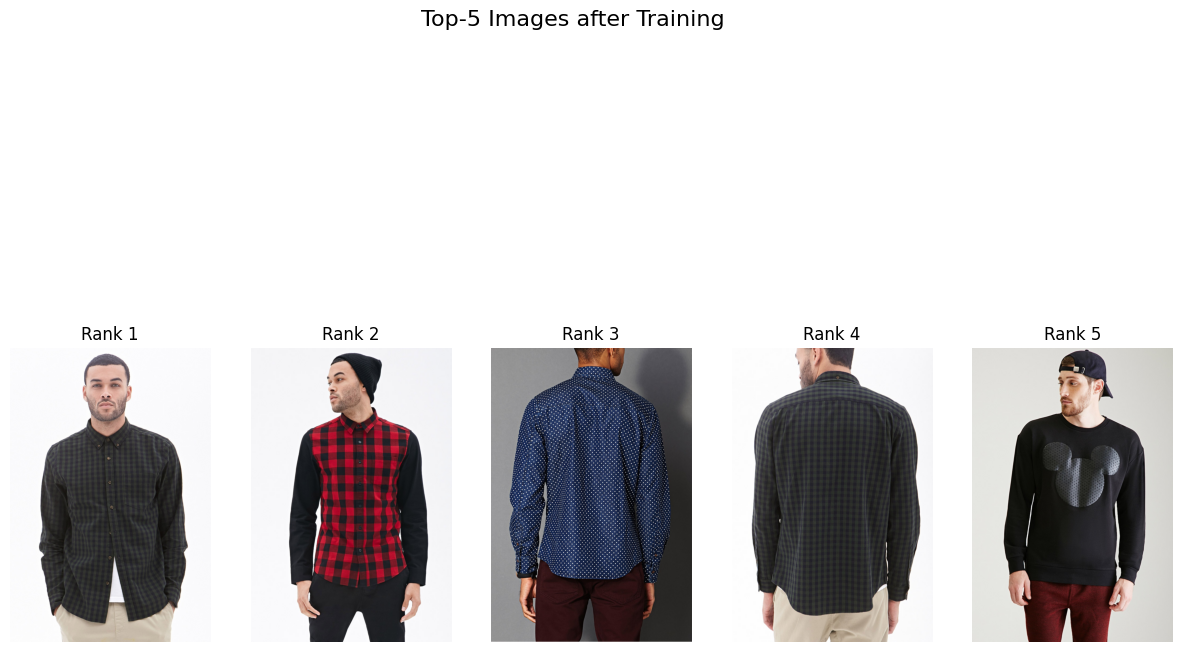

In [102]:

#모델을 학습 전!!초기상태!!로 복원
cmmodel.load_state_dict(torch.load("cmclip_initial_weights.pth"))# Cross-Modal Attention 모델 초기화,  cross modal attention은 encoder부분에서 적용되어야 하므로 이런식으로 바꾸어봄

# Cross-Modal Encoder 초기화
embed_dim = 512   # CLIP 모델의 임베딩 크기
num_heads = 8     # Attention 헤드 수
num_layers = 4    # Transformer 레이어 수
image_dim = 512   # 이미지 특징 크기
text_dim = 512    # 텍스트 특징 크기

# # CrossModalEncoder 생성
# cross_modal_encoder = CrossModalEncoder(
#     image_dim=image_dim,
#     text_dim=text_dim,
#     hidden_dim=embed_dim,
#     num_heads=num_heads,
#     num_layers=num_layers
# ).to(device)

# # Cross-Modal Attention Model 생성
# cross_modal_model = CrossModalAttentionModel(model, cross_modal_encoder).to(device).float()

# 학습

# Optimizer 설정
optimizer = torch.optim.AdamW(cmmodel.parameters(), lr=1e-6)
temperature = 0.1
num_epochs = 1

for epoch in range(num_epochs):
    cmmodel.train()
    total_loss = 0

    for images, texts, _ in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = images.to(device)
       
        texts = clip.tokenize(texts, truncate=True).to(device)

        optimizer.zero_grad()

        # Forward pass
        attn_output, image_features, text_features = cmmodel(images, texts)
        # Ensure text_features has the correct shape
        text_features = text_features.squeeze(1)  # Removes the unnecessary sequence dimension

        print(f"attn_output shape: {attn_output.shape}")
        print(f"text_features shape: {text_features.shape}")

        # Contrastive Loss
        logits_per_image = (attn_output @ text_features.T) / temperature
        logits_per_text = logits_per_image.T
        labels = torch.arange(len(images)).to(device)
        loss = (F.cross_entropy(logits_per_image, labels) + F.cross_entropy(logits_per_text, labels)) / 2

        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader):.4f}")


    # 학습 후 테스트 데이터에서 쿼리와 가장 유사한 이미지 추출
print("Retrieving after training...")
top_k_afterCM = retrieve_images(query_text, test_dataloader, cmmodel, preprocess)

print("Top-5 matching images after training:")
for i, img_path in enumerate(top_k_afterCM):
    print(f"{i + 1}: {img_path}")

# 중복된 경로를 제거
corrected_image_pathsCM = [os.path.relpath(path, start="images/images/") for path in top_k_afterCM]

# 디렉토리 설정
output_dir = "./images/images"



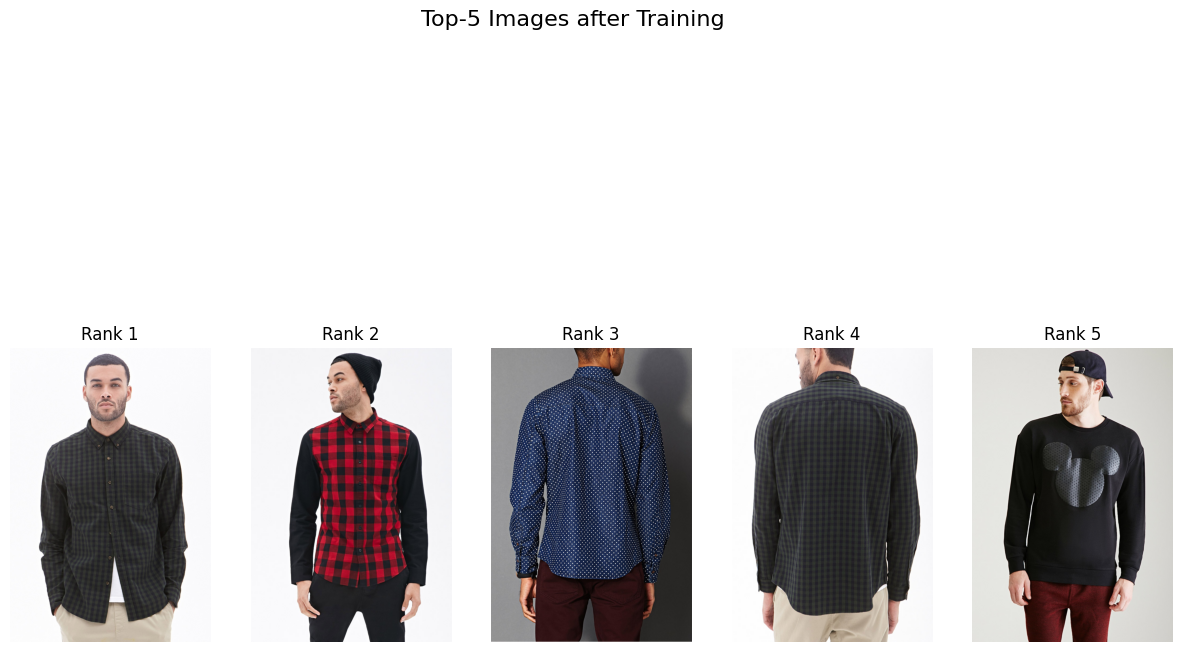

In [104]:

# 시각화 함수 호출
display_images(corrected_image_pathsCM, output_dir, title="Top-5 Images after Training")

In [103]:
#학습 후 테스트셋에 대한리컬 값 구하기
# 테스트셋에서 Recall@K 평가
recall_results = evaluate_recall(test_dataloader, cmmodel, preprocess)
print("Recall@K results on test dataset:")
for k, recall in recall_results.items():
    print(f"{k}: {recall:.4f}")

Processing test dataset: 100%|██████████| 266/266 [02:21<00:00,  1.88it/s]


8509
8509
8509
Recall@K results on test dataset:
Recall@1: 0.0007
Recall@5: 0.0018
Recall@10: 0.0029
